In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-10-16 15:02:57,089 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-16 15:02:57,091 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Illustration of PS and Scoring model

## Load data

In [8]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/15min_5to35_6R_120min_lib_im_ref_20241002_205908_418520/config_20241002_205908_418520.yaml"
ps_dir = "exp_20241002_223219_829060"

In [9]:
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)

In [11]:
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)

In [34]:
%autoreload 2
import torch
from peak_detection_2d.dataset.dataset import (
    build_transformation,
    MultiHDF5_MaskDataset,
)

random_state = cfg.RANDOM_SEED
cfg_peak_selection = cfg.PEAK_SELECTION
hdf5_files = cfg_peak_selection.TRAINING_DATA
#cfg_peak_selection.DATASET.RESIZE_SHAPE = (64, 64)
cfg_peak_selection.DATASET.RESIZE_SHAPE = (258, 258)
transformation, cfg_peak_selection.DATASET = build_transformation(
    cfg_peak_selection.DATASET
)
use_hint_channel = "hint" in cfg_peak_selection.DATASET.INPUT_CHANNELS
logging.info("Use hint channel: %s", use_hint_channel)
dataset = MultiHDF5_MaskDataset(
    hdf5_files[:5],
    use_hint_channel=use_hint_channel,
    transforms=transformation,
)

2024-10-03 10:57:57,227 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f32e43a94e0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f32e43a97e0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f32e43aa6b0>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f32e43abf10>]
2024-10-03 10:57:57,229 - root - INFO - Use hint channel: True


In [31]:
from peak_detection_2d.model.build_model import build_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_seg_model_path = cfg.PEAK_SELECTION.MODEL.RESUME_PATH
best_cls_model_path = cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH
# Load models
bst_seg_model = build_model(cfg.PEAK_SELECTION.MODEL)
checkpoint = torch.load(best_seg_model_path, map_location=device)
logging.info("best_seg_model_path: %s", best_seg_model_path)
bst_seg_model.load_state_dict(checkpoint["model_state_dict"])

bst_cls_model = build_model(cfg.PEAK_SELECTION.CLSMODEL)
checkpoint = torch.load(best_cls_model_path, map_location=device)
logging.info("best_cls_model_path: %s", best_cls_model_path)
bst_cls_model.load_state_dict(checkpoint["model_state_dict"])

2024-10-03 10:54:25,692 - root - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/15min_5to35_6R_120min_lib_im_ref_20241002_205908_418520/peak_selection/exp_20241002_223219_829060/model_backups/bst_seg_model_0.7582.pt


<All keys matched successfully>

2024-10-03 10:54:26,548 - peak_detection_2d.model.seg_model - INFO - Dropout applied to classifier with rate 0.5
2024-10-03 10:54:32,461 - root - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/15min_5to35_6R_120min_lib_im_ref_20241002_205908_418520/peak_selection/exp_20241002_223219_829060/model_backups/bst_cls_model_0.9086.pt


<All keys matched successfully>

2024-10-03 10:58:37,463 - root - INFO - Is target: 1
2024-10-03 10:58:37,465 - root - INFO - mask sum: 1765.912652457106
2024-10-03 10:58:37,466 - root - INFO - hint channel sum: -2921.0
2024-10-03 10:58:37,489 - peak_detection_2d.utils - INFO - hint channel sum: -292100000.0
2024-10-03 10:58:37,491 - peak_detection_2d.utils - INFO - hint channel non zero values: tensor([ -7000000., -15800000., -14400000., -32200000., -21700000., -48600000.,
        -20800000., -46400000., -13400000., -30000000.,  -6100000., -13600000.,
           400000.,   4000000.,   2600000.,  24000000.,   4800000.,  44100000.,
          6900000.,  64200000.,   5600000.,  52000000.,   3500000.,  32000000.,
          1300000.,  11900000.,  -8600000.,  -7700000., -21400000., -19200000.,
        -34300000., -30700000., -40000000., -35800000., -27200000., -24300000.,
        -14400000., -12900000.,  -1500000.,  -1400000.], dtype=torch.float64)


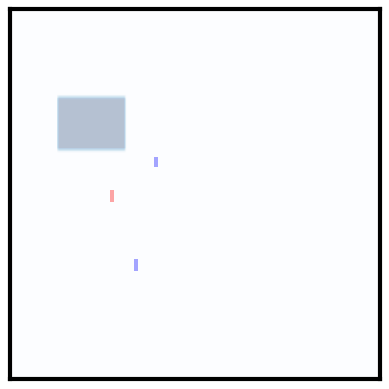

In [36]:
from peak_detection_2d.utils import single_inference

seg_output, cls_output = single_inference(
    datapoint=dataset[2], seg_model=bst_seg_model, cls_model=bst_cls_model
)

2024-10-03 11:00:26,574 - root - INFO - Is target: 1
2024-10-03 11:00:26,576 - root - INFO - mask sum: 1765.912652457106
2024-10-03 11:00:26,577 - root - INFO - hint channel sum: -2921.0
2024-10-03 11:00:26,594 - peak_detection_2d.utils - INFO - seg_out shape: torch.Size([258, 258])


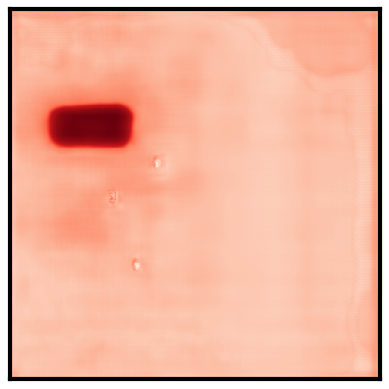

In [41]:
%autoreload 2
from peak_detection_2d.utils import plot_data_points_illustration
image, hint, label = dataset[2]
logging.info("Is target: %s", label["target"])
to_plot = {
    # "data": image[0].cpu(),
    # "hint_idx": hint.cpu(),
    "mask": label["mask"][0].cpu(),
    #"hint_channel": (image[2].cpu()) * 100000,
    "seg_out": seg_output[0][0].cpu(),
}
logging.info("mask sum: %s", label["mask"][0].sum().item())

logging.info("hint channel sum: %s", image[2].sum().item())
plot_data_points_illustration(to_plot, zoom_in=False, label="hide", log_data=False)

2024-10-03 11:14:44,648 - root - INFO - Is target: 1
2024-10-03 11:14:44,649 - root - INFO - mask sum: 1765.912652457106
2024-10-03 11:14:44,691 - root - INFO - hint channel sum: -2921.0
2024-10-03 11:14:44,705 - root - INFO - add label


     source  Decoy  mz_rank  MS1_frame_idx_left_exp  MS1_frame_idx_right_exp  \
6494   both  False    11887                   605.0                    616.0   

      MS1_frame_idx_left_ref  MS1_frame_idx_center_ref  \
6494                     587                       625   

      MS1_frame_idx_right_ref  IM_search_idx_left  IM_search_idx_right  \
6494                      663                 0.0                327.0   

      IM_search_idx_center  
6494                    90  


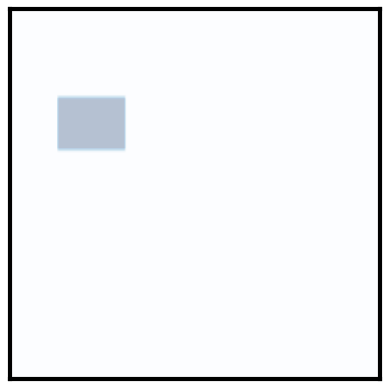

In [66]:
%autoreload 2
%matplotlib inline
from torch import layout
from peak_detection_2d.utils import plot_data_points_illustration

# load dataset
i = 2
image, hint, label = dataset[i]
seg_output, cls_output = single_inference(
    datapoint=dataset[i], seg_model=bst_seg_model, cls_model=bst_cls_model
)
logging.info("Is target: %s", label["target"])
to_plot = {
    #"data": image[0].cpu(),
    #"hint_idx": hint.cpu(),
    "mask": label["mask"][0].cpu(),
    #"hint_channel": (image[2].cpu())*100000,
    #"seg_out": seg_output[0][0].cpu(),
}
logging.info("mask sum: %s", label["mask"][0].sum().item())

logging.info("hint channel sum: %s", image[2].sum().item())
plot_data_points_illustration(to_plot, zoom_in=False, label="mask", log_data=True)

row = maxquant_result_ref[maxquant_result_ref["mz_rank"] == label["pept_mz_rank"]]
if (True) and (not row["Decoy"].values[0]):
    logging.info("add label")
else:
    logging.info("no label since it is decoys")
print(
    row[
        [
            "source",
            "Decoy",
            "mz_rank",
            "MS1_frame_idx_left_exp",
            "MS1_frame_idx_right_exp",
            "MS1_frame_idx_left_ref",
            "MS1_frame_idx_center_ref",
            "MS1_frame_idx_right_ref",
            "IM_search_idx_left",
            "IM_search_idx_right",
            "IM_search_idx_center",
        
        ]
    ]
)
figure_path = os.path.join(cfg.RESULT_PATH, "paper_figures/example_illustrations")
os.makedirs(figure_path, exist_ok=True)
plt.savefig(os.path.join(figure_path, "example_mask_11887.png"), dpi=300, format = "png", bbox_inches='tight')

# Load data

In [3]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/config_20241003_074426_198157.yaml"
ps_dir = "exp_20241003_083433_946837"

In [4]:
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)

In [5]:
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)

mobility_values_df = pd.read_csv(os.path.join(cfg.RESULT_PATH, "mobility_values.csv"))
ms1scans = pd.read_csv(os.path.join(cfg.RESULT_PATH, "ms1scans.csv"))
pept_act_sum_ps_full_tdc = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    )
)

In [92]:
from utils.metrics import RT_metrics

rt_metrics = RT_metrics(
    maxquant_result_ref.loc[
        (maxquant_result_ref["source"] == "both") & (maxquant_result_ref["Decoy"] == 0),
        "mobility_values_center_exp",
    ],
    maxquant_result_ref.loc[
        (maxquant_result_ref["source"] == "both") & (maxquant_result_ref["Decoy"] == 0),
        "mobility_values_center_ref",
    ],
)
rt_metrics.CalcDeltaRTwidth()

0.025385155871059828

In [93]:
maxquant_result_ref.loc[
    (maxquant_result_ref["source"] == "both") & (maxquant_result_ref["Decoy"] == 0),
    "1/K0 length",
].describe()

count    44731.000000
mean         0.079299
std          0.036600
min          0.010497
25%          0.053957
50%          0.071868
75%          0.095912
max          0.406215
Name: 1/K0 length, dtype: float64

prediction 1/K0: 0.047358468378823085

## Testset: Generate examples

In [39]:
test_pred_df = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "results", "test_pred_df.csv"
    )
)
# test_pred_df = pd.merge(test_pred_df, maxquant_result_ref, on=["mz_rank", "Decoy"])
test_pred_df = pd.merge(test_pred_df, maxquant_result_ref, on=["mz_rank", "Decoy"])

In [43]:
%autoreload 2
from peak_detection_2d.infer_on_pept_act import infer_on_pept_act

test_pred_df_low_conf_decoys = test_pred_df[
    (test_pred_df["target_decoy_score"] < 0.5) & (test_pred_df["Decoy"] == 1) & (test_pred_df["per_image_weighted_iou_metric"] < 0.5)
]
test_pred_df_low_conf_decoys = test_pred_df_low_conf_decoys.sample(10)

In [44]:
infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg.PEAK_SELECTION.MODEL.RESUME_PATH,
    best_cls_model_path=cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref.loc[
        maxquant_result_ref["mz_rank"].isin(test_pred_df_low_conf_decoys["mz_rank"])
    ],
    ps_exp_dir=os.path.join(
        "/cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures", "fig2_PS"
    ),
    plot_samples=True,
    add_label_mask=True,
    dataset_name="test_low_conf_decoy",
)

2024-10-16 16:31:54,398 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f3e6de2d2a0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f3e57921cc0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f3e579218a0>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f3df211af80>]
2024-10-16 16:31:56,423 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_20241003_083433_946837/model_backups/bst_seg_model_0.7183.pt
2024-10-16 16:31:57,242 - peak_detection_2d.model.seg_model - INFO - Dropout applied to classifier with rate 0.5
2024-10-16 16:31:57,727 - peak_detection_2d.infer_on_pept_act - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_

In [45]:
%autoreload 2
from peak_detection_2d.infer_on_pept_act import infer_on_pept_act
test_pred_df_high_conf_decoys = test_pred_df[
    (test_pred_df["target_decoy_score"] > 0.8) & (test_pred_df["Decoy"] == 1)
]
test_pred_df_high_conf_sample = test_pred_df_high_conf_decoys.sample(10)

In [20]:
infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg.PEAK_SELECTION.MODEL.RESUME_PATH,
    best_cls_model_path=cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref.loc[
        maxquant_result_ref["mz_rank"].isin(test_pred_df_high_conf_sample["mz_rank"])
    ],
    ps_exp_dir=os.path.join(
        "/cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures", "fig2_PS"
    ),
    plot_samples=True,
    add_label_mask=True,
    dataset_name="test_high_conf_decoy",
)

2024-10-16 15:38:27,899 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f3e90609d20>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f3e90608c70>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f3e90609ae0>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f3e90608520>]
2024-10-16 15:38:29,701 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_20241003_083433_946837/model_backups/bst_seg_model_0.7183.pt
2024-10-16 15:38:30,461 - peak_detection_2d.model.seg_model - INFO - Dropout applied to classifier with rate 0.5
2024-10-16 15:38:30,901 - peak_detection_2d.infer_on_pept_act - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_

In [24]:
test_pred_df_low_wiou_targets = test_pred_df[
    (test_pred_df["per_image_weighted_iou_metric"] < 0.2) & (test_pred_df["Decoy"] == 0)
]
test_pred_df_low_wiou_targets = test_pred_df_low_wiou_targets.sample(10)

In [25]:
infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg.PEAK_SELECTION.MODEL.RESUME_PATH,
    best_cls_model_path=cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref.loc[
        maxquant_result_ref["mz_rank"].isin(test_pred_df_low_wiou_targets["mz_rank"])
    ],
    ps_exp_dir=os.path.join(
        "/cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures", "fig2_PS"
    ),
    add_label_mask=True,
    plot_samples=True,
    dataset_name="test_low_wiou_targets",
)

2024-10-16 15:53:37,443 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f3e903b3880>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f3dda5d7160>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f3dda5d6980>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f3e9c3bffa0>]
2024-10-16 15:53:39,244 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_20241003_083433_946837/model_backups/bst_seg_model_0.7183.pt
2024-10-16 15:53:40,042 - peak_detection_2d.model.seg_model - INFO - Dropout applied to classifier with rate 0.5
2024-10-16 15:53:40,457 - peak_detection_2d.infer_on_pept_act - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_

In [28]:
test_pred_df_mid_high_wiou_targets = test_pred_df[
    (test_pred_df["per_image_weighted_iou_metric"] > 0.5) & (test_pred_df["Decoy"] == 0)
]
test_pred_df_mid_high_wiou_targets_sample = test_pred_df_mid_high_wiou_targets.sample(
    10
)

In [29]:
infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg.PEAK_SELECTION.MODEL.RESUME_PATH,
    best_cls_model_path=cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref.loc[
        maxquant_result_ref["mz_rank"].isin(
            test_pred_df_mid_high_wiou_targets_sample["mz_rank"]
        )
    ],
    ps_exp_dir=os.path.join(
        "/cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures", "fig2_PS"
    ),
    add_label_mask=True,
    plot_samples=True,
    dataset_name="test_mid_high_wiou_targets",
)

2024-10-16 16:03:06,756 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f3e90479120>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f3e9047a140>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f3e9047a080>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f3dda63dc30>]
2024-10-16 16:03:08,605 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_20241003_083433_946837/model_backups/bst_seg_model_0.7183.pt
2024-10-16 16:03:09,356 - peak_detection_2d.model.seg_model - INFO - Dropout applied to classifier with rate 0.5
2024-10-16 16:03:09,775 - peak_detection_2d.infer_on_pept_act - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_

In [31]:
test_pred_df_low_int_targets = test_pred_df[
    (test_pred_df["sum_intensity"] < 100) & (test_pred_df["Decoy"] == 0)
]
test_pred_df_low_int_targets_sample = test_pred_df_low_int_targets.sample(20)

In [32]:
infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg.PEAK_SELECTION.MODEL.RESUME_PATH,
    best_cls_model_path=cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref.loc[
        maxquant_result_ref["mz_rank"].isin(
            test_pred_df_low_int_targets_sample["mz_rank"]
        )
    ],
    ps_exp_dir=os.path.join(
        "/cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures", "fig2_PS"
    ),
    add_label_mask=True,
    plot_samples=True,
    dataset_name="test_low_intensity_targets",
)

2024-10-16 16:06:10,678 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f3df1693040>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f3df1691660>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f3df1690880>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f3df1693fa0>]
2024-10-16 16:06:12,502 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_20241003_083433_946837/model_backups/bst_seg_model_0.7183.pt
2024-10-16 16:06:13,247 - peak_detection_2d.model.seg_model - INFO - Dropout applied to classifier with rate 0.5
2024-10-16 16:06:13,650 - peak_detection_2d.infer_on_pept_act - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/30min_3to45_7R_120min_lib_im_ref_20241002_165602_293498/peak_selection/exp_

## Testset: Intensity after peak selection on testset

2024-10-04 09:12:38,784 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 8935
2024-10-04 09:12:38,785 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 8935
2024-10-04 09:12:38,787 - result_analysis.result_analysis - INFO - Number of entries after filtering 5293
2024-10-04 09:12:38,789 - result_analysis.result_analysis - INFO - Removing decoy entries, number of entries before filtering 5293
2024-10-04 09:12:38,790 - result_analysis.result_analysis - INFO - Number of entries after filtering 3915
2024-10-04 09:12:38,908 - result_analysis.result_analysis - INFO - Number of entries after merging 3915 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'm

Data:  Intensity_log sum_intensity_log , slope =  0.936 , intercept =  -0.183 , PearsonR =  0.73 , SpearmanR =  0.765


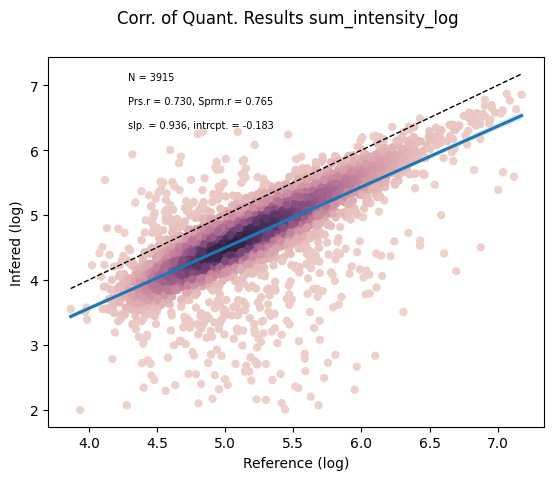

In [68]:
from result_analysis.result_analysis import SWAPSResult

ps_exp_results_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results")
# test_pred_df["log_sum_intensity"] = np.log10(test_pred_df["sum_intensity"] + 1)
test_pred_df_filtered_by_intensity = test_pred_df.loc[
    (test_pred_df["log_sum_intensity"] > 2) & (test_pred_df["target_decoy_score"] > 0.2)
]
sbs_ims_result = SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    # maxquant_merge_df=maxquant_result_ref,
    pept_act_sum_df=test_pred_df,
    infer_intensity_col="sum_intensity",
    fdr_thres=None,
    log_sum_intensity_thres=2,
    save_dir=None,
    include_decoys=True,
    # sum_raw=test_pred_df,
    # sum_gaussian=train_label_df,
    # ims=True,
    # other_cols=other_cols
)
sbs_ims_result.plot_intensity_corr(
    # ref_col="Intensity",
    # inf_col="sum_intensity",
    # contour=False,
    # save_dir=ps_exp_results_dir,
    # group_by="Leading razor protein",
)

In [53]:
test_pred_df["Decoy"].value_counts()

Decoy
False    4471
True     4464
Name: count, dtype: int64

In [9]:
%autoreload 2
from peak_detection_2d.utils import calc_fdr_and_thres

pred_df_new = calc_fdr_and_thres(
    test_pred_df,
    score_col="target_decoy_score",
    filter_dict={"log_sum_intensity": [0, 100]},
    return_plot=True,

    save_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"), dataset_name = "testset"
)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-30 08:54:07,780 - peak_detection_2d.utils - INFO - Number of entries before filtering: 6919
2024-08-30 08:54:07,784 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [0, 100]: 6919


In [10]:
%autoreload 2
from peak_detection_2d.utils import plot_roc_auc
plot_roc_auc(test_pred_df, 
             save_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"), dataset_name = "testset"
             #filter_dict={"log_sum_intensity": [2, 100]} 
             )

0.764066413888336

In [11]:
%autoreload 2
from peak_detection_2d.utils import plot_target_decoy_distr

plot_target_decoy_distr(test_pred_df, 
                        threshold=[0.07, 2], 
                        save_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"), 
                        dataset_name = "testset", 
                        main_plot_type="scatter")

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/utils.py:580: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x=0.85, y=8, s=f"N targets: {td_cou

In [12]:
from result_analysis.result_analysis import SBSResult

test_pred_df_filtered_by_intensity = test_pred_df.loc[
    (test_pred_df["target_decoy_score"] > 0.33)
    & (test_pred_df["log_sum_intensity"] > 1)
    & (test_pred_df["Decoy"] == 0),
]
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_merge_df=maxquant_result_ref,
    pept_act_sum_df_list=[test_pred_df_filtered_by_intensity],
    # sum_raw=test_pred_df,
    # sum_gaussian=train_label_df,
    ims=True,
    # other_cols=other_cols
)
sbs_ims_result.plot_intensity_corr(
    ref_col="Intensity",
    inf_col="sum_intensity",
    contour=False,
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    # group_by="Leading razor protein",
)

2024-08-30 08:54:10,633 - result_analysis.result_analysis - INFO - Reference shape: (178723, 112)
2024-08-30 08:54:10,663 - result_analysis.result_analysis - INFO - No grouping, show precurosr level correlation


Data:  Intensity_log sum_intensity_log , slope =  1.087 , intercept =  -0.756 , PearsonR =  0.894 , SpearmanR =  0.88


# Figure 2: Peak selection model performance
Use only test_pred_df

## Choose colors

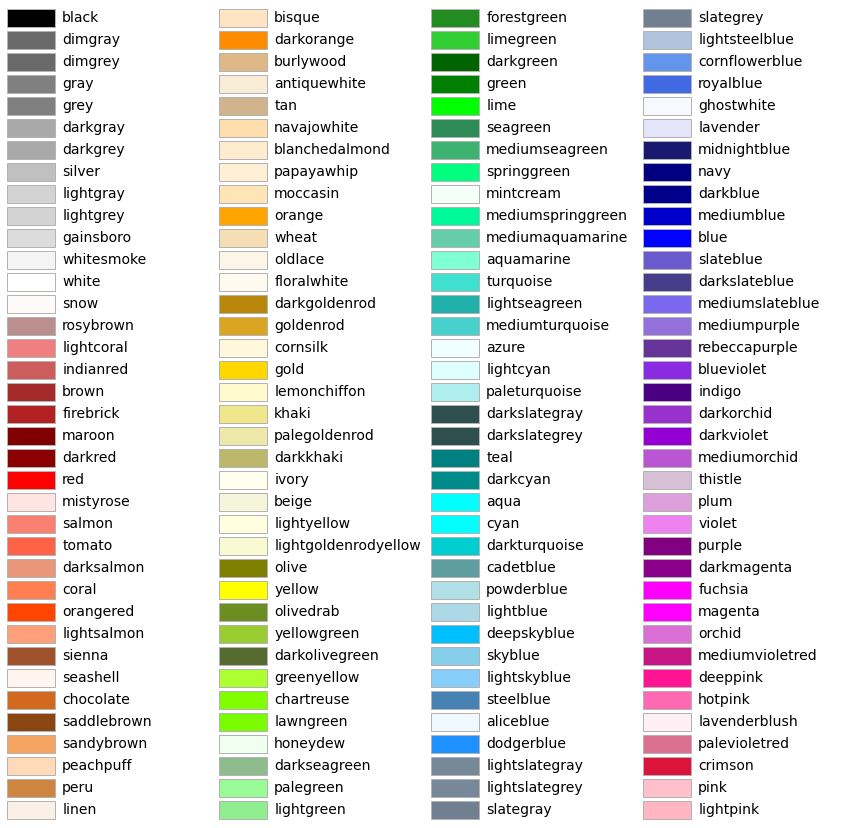

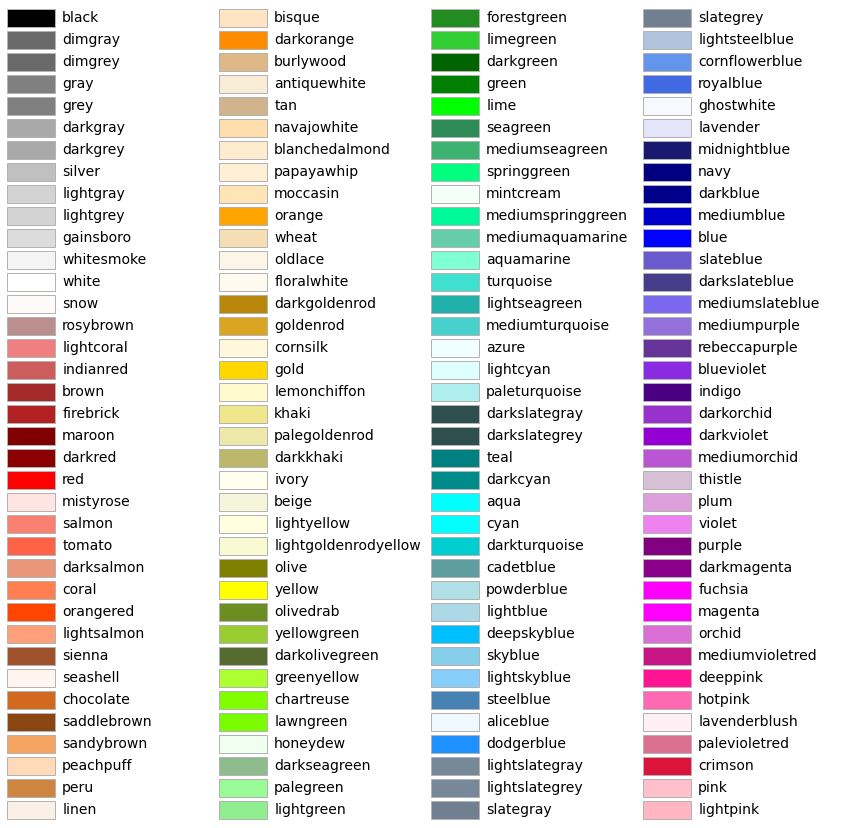

In [46]:
from utils.tools import plot_colortable
import matplotlib.colors as mcolors

plot_colortable(mcolors.CSS4_COLORS)

In [47]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#FF5733", "#33FF57", "#3357FF"])  # Custom colors
custom_labels = ["Targets", "Decoys"]  # Custom label names

## Plot

In [50]:
test_pred_df_full = pd.merge(
    left=test_pred_df,
    right=maxquant_result_ref[["mz_rank", "Decoy"]],
    on=["mz_rank", "Decoy"],
    how="left",
)
test_pred_df_full["Data"] = "Target"
test_pred_df_full.loc[test_pred_df_full["Decoy"], "Data"] = "Decoy"

In [48]:
ps_exp_dir = "/cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/"
os.makedirs(ps_exp_dir, exist_ok=True)

## Test set targets

In [51]:
test_pred_df_targets = test_pred_df_full.loc[~test_pred_df_full["Decoy"]]
test_pred_df_targets["Pass Intensity Filter"] = (
    test_pred_df_targets["log_sum_intensity"] >= 2
)
test_pred_df_targets["Pass TD Score Filter"] = (
    test_pred_df_targets["target_decoy_score"] >= 0.2
)
test_pred_df_targets["Pass Both Filter"] = (
    test_pred_df_targets["Pass Intensity Filter"]
    & test_pred_df_targets["Pass TD Score Filter"]
)

/tmp/ipykernel_731725/2895444544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pred_df_targets["Pass Intensity Filter"] = (
/tmp/ipykernel_731725/2895444544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pred_df_targets["Pass TD Score Filter"] = (
/tmp/ipykernel_731725/2895444544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Data:  target_decoy_score log_sum_intensity , slope =  1.637 , intercept =  3.388 , PearsonR =  0.6 , SpearmanR =  0.57


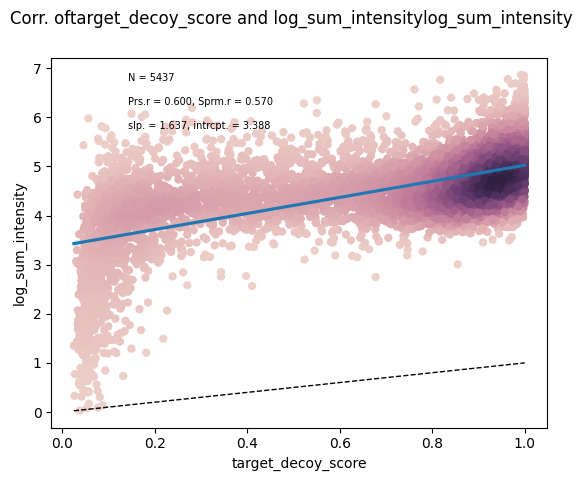

(array([4.9724484 , 4.73482148, 3.59636634, ..., 4.97061243, 4.05985257,
        4.60659222]),
 array([0.11702096, 0.33817638, 0.51134877, ..., 0.02194875, 1.49574087,
        0.20808614]),
 (array([   0,    2,    6, ..., 8931, 8933, 8934]),))

In [72]:
from utils.plot import plot_scatter

plot_scatter(
    x=test_pred_df_full["target_decoy_score"],
    y=test_pred_df_full["log_sum_intensity"],
)

In [73]:
import seaborn as sns
from utils.plot import save_plot

plt.rc("font", size=14)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    data=test_pred_df_targets,
    x="log_sum_intensity",
    hue="Pass Intensity Filter",
    palette={False: "#d8a6a6", True: "#a00000"},
    hue_order=[False, True],
    # color=["olivedrab", "tomato"],
    multiple="stack",
    bins=20,
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title("Test Set Inferred Intensity")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_test_targets",
)

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log_sum_intensity', ylabel='Count'>

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, 'Test Set Inferred Intensity')

2024-10-16 16:52:55,283 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_test_targets.png
2024-10-16 16:52:55,560 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_test_targets.svg


In [72]:
import seaborn as sns

plt.rc("font", size=14)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    data=test_pred_df_targets,
    x="per_image_weighted_iou_metric",
    hue="Pass Intensity Filter",
    palette={False: "#d8a6a6", True: "#a00000"},
    hue_order=[False, True],
    # color=["olivedrab", "tomato"],
    multiple="stack",
    bins=20,
)
plt.xlabel("Weighted IoU")
plt.title("Test Set Weighted IoU")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="weighted_iou_test_targets",
)

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='per_image_weighted_iou_metric', ylabel='Count'>

Text(0.5, 0, 'Weighted IoU')

Text(0.5, 1.0, 'Test Set Weighted IoU')

2024-10-16 16:52:52,034 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_weighted_iou_test_targets.png
2024-10-16 16:52:52,272 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_weighted_iou_test_targets.svg


In [54]:
test_pred_df_targets_filter_int = test_pred_df_targets[
    test_pred_df_targets["Pass Intensity Filter"]
]
(test_pred_df_targets_filter_int["per_image_weighted_iou_metric"] > 0.8).sum() / len(
    test_pred_df_targets_filter_int
)
(test_pred_df_targets_filter_int["per_image_weighted_iou_metric"] < 0.2).sum() / len(
    test_pred_df_targets_filter_int
)

0.7537675606641124

0.1478927203065134

# Figure 3: FDR Eval and Control

## Specific examples

In [37]:
test_pred_df_targets_high_wiou_low_td_score = test_pred_df_targets.loc[
    (test_pred_df_targets["per_image_weighted_iou_metric"] > 0.8)
    & (test_pred_df_targets["target_decoy_score"] < 0.2)
    & (test_pred_df_targets["log_sum_intensity"] > 2)
].sample(10)

In [39]:
%autoreload 2
from peak_detection_2d.infer_on_pept_act import infer_on_pept_act

infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg.PEAK_SELECTION.MODEL.RESUME_PATH,
    best_cls_model_path=cfg.PEAK_SELECTION.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref.loc[
        maxquant_result_ref["mz_rank"].isin(
            test_pred_df_targets_high_wiou_low_td_score["mz_rank"]
        )
    ],
    ps_exp_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir),
    plot_samples=True,
    add_label_mask=True,
    dataset_name="test_high_wiou_low_td_target",
)

2024-09-18 14:58:21,686 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f7f8f726ef0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f7f8f726710>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f7f8f7273d0>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f7f8f726e30>]
2024-09-18 14:58:23,722 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240903_174407_457504/peak_selection/exp_20240903_193426_406274/model_backups/bst_seg_model_0.6696.pt
2024-09-18 14:58:24,979 - peak_detection_2d.infer_on_pept_act - INFO - best_cls_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240903_174407_457504/peak_selection/exp_20240903_193426_406274/model_backups/bst_cls_model_0.8871.pt
2024-09-18 14:58:25,031 - peak_detection_2d.infer_on_pept_act - INFO - Infer

## Test set TDC

In [55]:
peak_selection_tdc = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    )
)

In [56]:
test_pred_df_tdc = test_pred_df.loc[
    test_pred_df["mz_rank"].isin(peak_selection_tdc["mz_rank"])
]

## Test set decoys

In [57]:
test_pred_df_decoys = test_pred_df.loc[test_pred_df["Decoy"] == 1]
test_pred_df_decoys["Pass Intensity Filter"] = (
    test_pred_df_decoys["log_sum_intensity"] >= 2
)
test_pred_df_decoys["Pass TD Score Filter"] = (
    test_pred_df_decoys["target_decoy_score"] >= 0.2
)
test_pred_df_decoys["Pass Both Filter"] = (
    test_pred_df_decoys["Pass Intensity Filter"]
    & test_pred_df_decoys["Pass TD Score Filter"]
)
# test_pred_df_decoys["Is Isolated Decoys"] = test_pred_df_decoys["mz_rank"].isin(
#     isolated_decoys
# )

/tmp/ipykernel_731725/24874052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pred_df_decoys["Pass Intensity Filter"] = (
/tmp/ipykernel_731725/24874052.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pred_df_decoys["Pass TD Score Filter"] = (
/tmp/ipykernel_731725/24874052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [61]:
test_pred_df_decoys.loc[
    test_pred_df_decoys["Pass Intensity Filter"], "Pass TD Score Filter"
].value_counts()

Pass TD Score Filter
True     937
False    441
Name: count, dtype: int64

In [62]:
944 + 609
944 / (944 + 609)

1553

0.6078557630392788

In [63]:
test_pred_df.loc[test_pred_df["target_decoy_score"] > 0.2]["Data"].value_counts()

Data
Target                3579
Non-Isolated Decoy     937
Name: count, dtype: int64

In [64]:
identified_target = test_pred_df.loc[
    (~test_pred_df["Decoy"]) & (test_pred_df["log_sum_intensity"] >= 2),
    "per_image_weighted_iou_metric",
]

In [65]:
(identified_target <= 0.2).sum() / identified_target.shape[0]

0.1478927203065134

In [75]:
import seaborn as sns
from utils.plot import save_plot

plt.rc("font", size=14)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    data=test_pred_df_decoys,
    x="log_sum_intensity",
    hue="Pass TD Score Filter",
    palette={False: "#d8a6a6", True: "#a00000"},
    hue_order=[False, True],
    # color=["olivedrab", "tomato"],
    multiple="stack",
    bins=20,
)
plt.vlines(x=2, ymin=0, ymax=3000, color="black", linestyle="--")
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title("Test Set Inferred Intensity of Decoys")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_test_decoys",
)

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log_sum_intensity', ylabel='Count'>

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, 'Test Set Inferred Intensity of Decoys')

2024-10-16 16:56:31,366 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_test_decoys.png
2024-10-16 16:56:31,651 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_test_decoys.svg


## Test set targets

In [66]:
test_pred_df_targets[test_pred_df_targets["Pass Intensity Filter"]]

,sum_intensity,mz_rank,out_score,target_decoy_score,per_image_weighted_dice_metric,per_image_weighted_iou_metric,Decoy,log_sum_intensity,Sequence,Length,...,MS1_frame_idx_right_ref,IsoMZ,IsoAbundance,mz_bin,mz_length,pept_batch_idx,Data,Pass Intensity Filter,Pass TD Score Filter,Pass Both Filter
0,122875.648438,103291.0,0.947929,0.968139,9.959431e-01,9.919190e-01,False,5.089469,EDSWTLFKPPPVFPVDNSSAK,21,...,1865,"[787.7307792879601, 788.0631242530267, 788.065...","[0.25065097614238496, 0.022905100132044685, 0....",787.73,11,8,Target,True,True,True
2,24924.570312,78204.0,0.963193,0.822961,7.749889e-01,6.326383e-01,False,4.396645,VTTVVATLGQGPER,14,...,1202,"[714.39682129248, 714.89533874008, 714.8984987...","[0.4534083375456066, 0.029832166397493615, 0.3...",714.40,8,6,Target,True,True,True
7,36028.617188,166149.0,0.711421,0.507720,8.771721e-01,7.812169e-01,False,4.556660,VRTDITYPAGFMDVISIDK,19,...,1863,"[1071.051545939275, 1071.550063386875, 1071.55...","[0.2814932367879886, 0.0236656581370854, 0.294...",1071.05,12,13,Target,True,True,True
9,9006.308594,97923.0,0.960244,0.948782,8.930428e-01,8.067546e-01,False,3.954595,LAMTPTERPHGSDICTSWPR,20,...,1111,"[771.3690819222634, 771.70142688733, 771.70353...","[0.2543615471003181, 0.027893017433604107, 0.2...",771.37,13,7,Target,True,True,True
11,6978.698730,154193.0,0.977943,0.859659,9.918917e-01,9.839138e-01,False,3.843837,VLHALQEAAPEVVQPTTVQSSTIPSLLR,28,...,1763,"[995.5525701534499, 995.8849151185167, 995.887...","[0.184255395488496, 0.024246301457991695, 0.26...",995.55,12,12,Target,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,2293.368652,157306.0,0.807449,0.229334,4.360398e-10,4.360398e-12,False,3.360663,HVQLVLGQLIDENYLDR,17,...,1864,"[1013.042369607145, 1013.540887054745, 1013.54...","[0.3158093817917953, 0.0288594348360768, 0.309...",1013.04,10,12,Target,True,True,True
8925,82925.523438,165581.0,0.882436,0.840786,9.885061e-01,9.772734e-01,False,4.918693,WEVLIIGPPDTLYEGGVFK,19,...,2225,"[1067.067521727825, 1067.566039175425, 1067.56...","[0.2780499812722463, 0.021343466197691157, 0.3...",1067.07,11,13,Target,True,True,True
8928,2205.228516,64391.0,0.538316,0.062748,4.494972e-01,2.899042e-01,False,3.343650,SSLLGSGDWHQYYDIVYMKPHGR,23,...,1479,"[678.0779639651425, 678.3272226889425, 678.328...","[0.1994525906681906, 0.024058935469284778, 0.2...",678.08,12,5,Target,True,False,False
8931,98300.734375,113720.0,0.975914,0.967017,9.971682e-01,9.943524e-01,False,4.992561,YYEGYYAAGPGYGGR,15,...,1161,"[822.3604357836, 822.8589532312, 822.862113201...","[0.3796696048426115, 0.02498049967287193, 0.31...",822.36,8,9,Target,True,True,True


In [101]:
import seaborn as sns

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    data=test_pred_df_targets[test_pred_df_targets["Pass Intensity Filter"]],
    x="per_image_weighted_iou_metric",
    hue="Pass TD Score Filter",
    palette={False: "#d8a6a6", True: "#a00000"},
    hue_order=[False, True],
    # color=["olivedrab", "tomato"],
    multiple="stack",
    bins=20,
)
plt.xlabel("Weighted IoU")
plt.title("Test Set Weighted IoU of Targets (Passed Intensity Filter)")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="weighted_iou_test_passed_int_filter_targets",
)

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='per_image_weighted_iou_metric', ylabel='Count'>

Text(0.5, 0, 'Weighted IoU')

Text(0.5, 1.0, 'Test Set Weighted IoU of Targets (Passed Intensity Filter)')

2024-10-17 10:58:35,082 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_weighted_iou_test_passed_int_filter_targets.png
2024-10-17 10:58:35,362 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_weighted_iou_test_passed_int_filter_targets.svg


In [32]:
test_pred_df_targets_filter_both = test_pred_df_targets[
    test_pred_df_targets["Pass Both Filter"]
]
(test_pred_df_targets_filter_both["per_image_weighted_iou_metric"] > 0.8).sum() / len(
    test_pred_df_targets_filter_both
)
(test_pred_df_targets_filter_both["per_image_weighted_iou_metric"] < 0.2).sum() / len(
    test_pred_df_targets_filter_both
)

0.8087968011632134

0.07778989458378771

# Figure 4: result from 120-minute ref library

## Get isolated decoys and compete signals

In [48]:
import pickle

try:
    with open(
        os.path.join(cfg.RESULT_PATH, "isolated_decoys.pkl"),
        "rb",
    ) as f:
        isolated_decoys_all = pickle.load(f)
except FileNotFoundError:
    logging.info("File not found, calculating isolated decoys")
    from postprocessing.fdr import generate_signal_compete_pairs

    signal_compete_all = generate_signal_compete_pairs(
        maxquant_dict=maxquant_result_ref, groupby_columns="mz_bin"
    )
    decoy_mz_ranks = set(
        maxquant_result_ref.loc[maxquant_result_ref["Decoy"], "mz_rank"]
    )
    from postprocessing.fdr import get_isolated_decoys_from_pairs

    isolated_decoys_set_pairs_all = get_isolated_decoys_from_pairs(
        result=signal_compete_all, decoy_mz_ranks=decoy_mz_ranks
    )
    from postprocessing.fdr import get_isolated_decoy_from_mzbins

    isolated_decoys_mzbins_set = get_isolated_decoy_from_mzbins(
        maxquant_result_ref=maxquant_result_ref,
    )
    from utils.plot import plot_venn2

    plot_venn2(
        set1=isolated_decoys_set_pairs_all,
        set2=isolated_decoys_mzbins_set,
        label1="shared_bin",
        label2="isolated_bin",
    )
    isolated_decoys_all = isolated_decoys_set_pairs_all.union(
        isolated_decoys_mzbins_set
    )

    variables = {
        "isolated_decoys_all": isolated_decoys_all,
        "isolated_decoys_mzbins_set": isolated_decoys_mzbins_set,
        "isolated_decoys_set_pairs_all": isolated_decoys_set_pairs_all,
    }
    with open(os.path.join(cfg.RESULT_PATH, "isolated_decoys.pkl"), "wb") as f:
        pickle.dump(variables, f)

In [112]:
import seaborn as sns

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
ax = sns.histplot(
    test_pred_df_full,
    x="target_decoy_score",
    hue="Data",
    fill=True,
    hue_order=["Decoy", "Target"],
    # palette=custom_cmap,
    multiple="dodge",
    common_norm=True,
    bins=20,
)
plt.xlabel("Confidence Score")
plt.title("30-minute Exp Library (Test Set) Confidence Score")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="confidence_score_30min_exp_testset",
)

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

Text(0.5, 0, 'Confidence Score')

Text(0.5, 1.0, '30-minute Exp Library (Test Set) Confidence Score')

2024-10-17 15:05:22,241 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_confidence_score_30min_exp_testset.png
2024-10-17 15:05:22,505 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_confidence_score_30min_exp_testset.svg


In [113]:
import seaborn as sns

pept_act_sum_ps_df_with_source = pd.merge(
    left=pept_act_sum_ps_df,
    right=maxquant_result_ref[["mz_rank", "source"]],
    on="mz_rank",
)

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data=pept_act_sum_ps_df_with_source.loc[
        pept_act_sum_ps_df_with_source["source"] == "ref"
    ],
    x="target_decoy_score",
    hue="Data",
    fill=True,
    hue_order=["Decoy", "Target"],
    # palette=custom_cmap,
    multiple="dodge",
    common_norm=True,
    bins=20,
)
plt.xlabel("Confidence Score")
plt.title("120-minute Ref Library Confidence Score")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="confidence_score_120min_ref",
)

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

Text(0.5, 0, 'Confidence Score')

Text(0.5, 1.0, '120-minute Ref Library Confidence Score')

2024-10-17 15:05:25,268 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_confidence_score_120min_ref.png
2024-10-17 15:05:25,517 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_confidence_score_120min_ref.svg


## Before PS and FDR control

In [78]:
pept_act_sum_df = pd.read_csv(
    os.path.join(cfg.RESULT_PATH, "results", "activation", "pept_act_sum.csv")
)
pept_act_sum_df_full = pd.merge(
    left=pept_act_sum_df, right=maxquant_result_ref[["mz_rank", "Decoy"]], on="mz_rank"
)
pept_act_sum_df_full["Data"] = "Target"
pept_act_sum_df_full.loc[pept_act_sum_df_full["Decoy"], "Data"] = "Decoy"
pept_act_sum_df_full["log_sum_intensity"] = np.log10(
    pept_act_sum_df_full["pept_act_sum"] + 1
)

In [79]:
pept_act_sum_df_full.columns

Index(['pept_act_sum', 'mz_rank', 'Decoy', 'Data', 'log_sum_intensity'], dtype='object')

In [80]:
import seaborn as sns

ax = sns.histplot(
    pept_act_sum_df_full,
    x="log_sum_intensity",
    hue="Data",
    fill=True,
    hue_order=["Decoy", "Target"],
    # palette=custom_cmap,
    multiple="dodge",
    common_norm=True,
    bins=20,
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title("Inferred Intensity All Candidates, Before Peak Selection")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_all_candidates_before_peak_selection",
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, 'Inferred Intensity All Candidates, Before Peak Selection')

2024-10-16 17:01:34,633 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_all_candidates_before_peak_selection.png
2024-10-16 17:01:34,948 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_all_candidates_before_peak_selection.svg


In [83]:
from result_analysis import result_analysis

swaps_result = result_analysis.SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_df_full,
    infer_intensity_col="pept_act_sum",
    fdr_thres=None,
    log_sum_intensity_thres=2,
    save_dir=ps_exp_dir,
)
swaps_result.plot_intensity_corr(contour=False, title=None, show_diag=False)

2024-10-16 17:05:16,507 - result_analysis.result_analysis - INFO - Drop na values in pept_act_sum, Pept activation sum entries: 186257
2024-10-16 17:05:16,507 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 186257
2024-10-16 17:05:16,514 - result_analysis.result_analysis - INFO - Number of entries after filtering 186257
2024-10-16 17:05:16,517 - result_analysis.result_analysis - INFO - Removing decoy entries, number of entries before filtering 186257
2024-10-16 17:05:16,522 - result_analysis.result_analysis - INFO - Number of entries after filtering 93323
2024-10-16 17:05:16,753 - result_analysis.result_analysis - INFO - Number of entries after merging 51319 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...


## After PS, before FDR

In [84]:
pept_act_sum_ps_df = pd.read_csv(
    os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "pept_act_sum_ps.csv")
)
pept_act_sum_ps_df["log_sum_intensity"] = np.log10(
    pept_act_sum_ps_df["sum_intensity"] + 1
)
pept_act_sum_ps_df = pd.merge(
    left=maxquant_result_ref[["mz_rank", "Decoy"]],
    right=pept_act_sum_ps_df,
    on="mz_rank",
)
pept_act_sum_ps_df["Data"] = "Target"
pept_act_sum_ps_df.loc[pept_act_sum_ps_df["Decoy"], "Data"] = "Decoy"

In [86]:
import seaborn as sns

ax = sns.histplot(
    pept_act_sum_ps_df,
    x="log_sum_intensity",
    hue="Data",
    fill=True,
    hue_order=["Decoy", "Target"],
    # palette=custom_cmap,
    multiple="dodge",
    common_norm=True,
    bins=20,
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title("Inferred Intensity All Candidates, After PS, Before FDR")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_all_candidates_after_peak_selection_and_before_FDR",
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, 'Inferred Intensity All Candidates, After PS, Before FDR')

2024-10-16 17:06:54,438 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_all_candidates_after_peak_selection_and_before_FDR.png
2024-10-16 17:06:54,734 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_all_candidates_after_peak_selection_and_before_FDR.svg


In [93]:
from result_analysis import result_analysis

swaps_result = result_analysis.SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_ps_df,
    infer_intensity_col="sum_intensity",
    fdr_thres=None,
    log_sum_intensity_thres=2,
    save_dir=ps_exp_dir,
)
swaps_result.plot_intensity_corr(contour=False, title=None, show_diag=False)

2024-10-16 17:14:00,622 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 186257
2024-10-16 17:14:00,623 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 186257
2024-10-16 17:14:00,628 - result_analysis.result_analysis - INFO - Number of entries after filtering 99726
2024-10-16 17:14:00,630 - result_analysis.result_analysis - INFO - Removing decoy entries, number of entries before filtering 99726
2024-10-16 17:14:00,634 - result_analysis.result_analysis - INFO - Number of entries after filtering 74620
2024-10-16 17:14:00,849 - result_analysis.result_analysis - INFO - Number of entries after merging 46812 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
 

## After PS and FDR control

In [88]:
to_plot = pd.merge(
    left=pept_act_sum_ps_df[["mz_rank", "Data"]],
    right=pept_act_sum_ps_full_tdc,
    on=["mz_rank"],
    how="left",
)
to_plot["log_sum_intensity"].fillna(0, inplace=True)
ax = sns.histplot(
    to_plot,
    x="log_sum_intensity",
    hue="Data",
    fill=True,
    hue_order=["Decoy", "Target"],
    # palette=custom_cmap,
    multiple="dodge",
    common_norm=True,
    bins=20,
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title("Inferred Intensity All Candidates, After PS and FDR")
save_plot(
    save_dir=ps_exp_dir,
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_all_candidates_after_peak_selection_and_FDR",
)

/tmp/ipykernel_731725/1272867969.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to_plot["log_sum_intensity"].fillna(0, inplace=True)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:9

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, 'Inferred Intensity All Candidates, After PS and FDR')

2024-10-16 17:08:51,922 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_all_candidates_after_peak_selection_and_FDR.png
2024-10-16 17:08:52,254 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/hist_inferred_intensity_all_candidates_after_peak_selection_and_FDR.svg


In [91]:
from result_analysis import result_analysis

swaps_result = result_analysis.SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_ps_full_tdc,
    infer_intensity_col="sum_intensity",
    fdr_thres=0.2,
    log_sum_intensity_thres=2,
    save_dir=ps_exp_dir,
    # save_dir=eval_dir,
)
swaps_result.plot_intensity_corr(contour=False, show_diag=False, title=None)

2024-10-16 17:11:38,249 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 79795
2024-10-16 17:11:38,250 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 79795
2024-10-16 17:11:38,256 - result_analysis.result_analysis - INFO - Number of entries after filtering 79795
2024-10-16 17:11:38,258 - result_analysis.result_analysis - INFO - FDR threshold is larger than the maximum FDR, set to maximum FDR 0.161
2024-10-16 17:11:38,259 - result_analysis.result_analysis - INFO - Calculating FDR results after filter...
2024-10-16 17:11:38,263 - peak_detection_2d.utils - INFO - Number of entries before filtering: 79795


2024-10-16 17:11:38,269 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [0, 100]: 79795
2024-10-16 17:11:44,501 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fdr_id_targets_result_analysis.png
2024-10-16 17:11:52,179 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fdr_id_targets_result_analysis.svg
2024-10-16 17:11:52,183 - result_analysis.result_analysis - INFO - Filtering the data by FDR threshold 0.161, number of entries before filtering 79795
2024-10-16 17:11:52,192 - result_analysis.result_analysis - INFO - Score threshold 0.0282391110315487, number of entries after filtering 79790
2024-10-16 17:11:52,193 - result_analysis.result_analysis - INFO - Removing decoy entries, number of entries before filtering 79790
2024-10-16 17:11:52,198 - result_analysis.result_analysis - INFO - Number of entries after filtering 68726
2024-10-16 17:11:5

## Intesnity distribution of exp and ref source

### 30min

In [99]:
from result_analysis import result_analysis

swaps_result = result_analysis.SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_ps_full_tdc,
    infer_intensity_col="sum_intensity",
    fdr_thres=0.2,
    log_sum_intensity_thres=2,
    save_dir=os.path.join(ps_exp_dir, "fig4_application"),
)

filtered_result = swaps_result.pept_act_sum
filtered_result_with_source = pd.merge(
    left=maxquant_result_ref[["mz_rank", "source"]],
    right=filtered_result,
    on="mz_rank",
    how="right",
)
filtered_result_with_source["source"].value_counts()
filtered_result_with_source["Identified By"] = "MaxQuant and SWAPS"
filtered_result_with_source.loc[
    filtered_result_with_source["source"] == "ref", "Identified By"
] = "SWAPS"
filtered_result_with_source["Identified By"].value_counts()

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
swaps_result.plot_intensity_corr(
    show_diag=False, title="30-min LC Gradient with 120-min Library", contour=False
)

import seaborn as sns

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    filtered_result_with_source,
    x="log_sum_intensity",
    hue="Identified By",
    # fill=True,
    common_norm=True,
    multiple="dodge",
    bins=30,
    kde=True,
    # cumulative=True,
    palette={"SWAPS": "green", "MaxQuant and SWAPS": "tan"},
    # palette={"120min library": "darkorange", "30min library": "royalblue"},
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title("30-min LC Gradient with 120-min Library")
save_plot(
    save_dir=os.path.join(ps_exp_dir, "fig4_application"),
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_30min_120min_library",
)

2024-10-17 10:54:31,654 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 79795
2024-10-17 10:54:31,655 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 79795
2024-10-17 10:54:31,660 - result_analysis.result_analysis - INFO - Number of entries after filtering 79795
2024-10-17 10:54:31,661 - result_analysis.result_analysis - INFO - FDR threshold is larger than the maximum FDR, set to maximum FDR 0.161
2024-10-17 10:54:31,662 - result_analysis.result_analysis - INFO - Calculating FDR results after filter...
2024-10-17 10:54:31,664 - peak_detection_2d.utils - INFO - Number of entries before filtering: 79795
2024-10-17 10:54:31,669 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [0, 100]: 79795
2024-10-17 10:54:37,929 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_fi

source
both    41223
ref     23760
exp      3743
Name: count, dtype: int64

Identified By
MaxQuant and SWAPS    44966
SWAPS                 23760
Name: count, dtype: int64

### 15min

In [106]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/15min_5to35_6R_120min_lib_im_ref_20241002_205908_418520/config_20241002_205908_418520.yaml"
ps_dir = "exp_20241002_223219_829060"

from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)
# mobility_values_df = pd.read_csv(os.path.join(cfg.RESULT_PATH, "mobility_values.csv"))
# ms1scans = pd.read_csv(os.path.join(cfg.RESULT_PATH, "ms1scans.csv"))
pept_act_sum_ps_full_tdc = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    )
)

In [107]:
lc = "15-min"
lib = "120-min"

In [108]:
from result_analysis import result_analysis

swaps_result = result_analysis.SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_ps_full_tdc,
    infer_intensity_col="sum_intensity",
    fdr_thres=0.2,
    log_sum_intensity_thres=2,
    save_dir=os.path.join(ps_exp_dir, "fig4_application", lc + lib),
)

filtered_result = swaps_result.pept_act_sum
filtered_result_with_source = pd.merge(
    left=maxquant_result_ref[["mz_rank", "source"]],
    right=filtered_result,
    on="mz_rank",
    how="right",
)
filtered_result_with_source["source"].value_counts()
filtered_result_with_source["Identified By"] = "MaxQuant and SWAPS"
filtered_result_with_source.loc[
    filtered_result_with_source["source"] == "ref", "Identified By"
] = "SWAPS"
filtered_result_with_source["Identified By"].value_counts()

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
swaps_result.plot_intensity_corr(
    show_diag=False, title=f"{lc} LC Gradient with {lib} Library", contour=False
)

import seaborn as sns

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    filtered_result_with_source,
    x="log_sum_intensity",
    hue="Identified By",
    # fill=True,
    common_norm=True,
    multiple="dodge",
    bins=30,
    kde=True,
    # cumulative=True,
    palette={"SWAPS": "green", "MaxQuant and SWAPS": "tan"},
    # palette={"120min library": "darkorange", "30min library": "royalblue"},
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title(f"{lc} LC Gradient with {lib} Library")
save_plot(
    save_dir=os.path.join(ps_exp_dir, "fig4_application", lc + lib),
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_30min_120min_library",
)

2024-10-17 11:09:07,366 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 70750
2024-10-17 11:09:07,367 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 70750
2024-10-17 11:09:07,372 - result_analysis.result_analysis - INFO - Number of entries after filtering 70750
2024-10-17 11:09:07,373 - result_analysis.result_analysis - INFO - Calculating FDR results after filter...
2024-10-17 11:09:07,376 - peak_detection_2d.utils - INFO - Number of entries before filtering: 70750
2024-10-17 11:09:07,381 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [0, 100]: 70750
2024-10-17 11:09:13,015 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/15-min120-min/fdr_id_targets_result_analysis.png
2024-10-17 11:09:19,805 - utils.plot - INFO - Save plot at

source
ref     28179
both    27096
exp      1793
Name: count, dtype: int64

Identified By
MaxQuant and SWAPS    28889
SWAPS                 28179
Name: count, dtype: int64

<Figure size 800x600 with 0 Axes>

2024-10-17 11:09:20,285 - result_analysis.result_analysis - INFO - Number of entries after merging 28889 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'sum_intensity', 'out_score', 'target_decoy_score', 'Decoy_y',
       'TD pair id_y', 'log_sum_intensity', 'competition', 'Target', 'fdr',
       'N_identified_target'],
      dtype='object', length=123)
2024-10-17 11:09:20,365 - utils.plot - INFO - Data: Intensity_log, sum_intensity_log, slope = 0.982, intercept = -0.102, Pearson's R = 0.848, Spearman's R = 0.846
2024-10-17 11:09:36,344 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/15-min120-min/CorrQuantification_sum_intensity_log_fdr_0.2_log_int_2.png
2024-10-17 11:09:38,603 - utils.plot - INFO - Save plot at /cmnfs/p

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

<Axes: xlabel='log_sum_intensity', ylabel='Count'>

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, '15-min LC Gradient with 120-min Library')

2024-10-17 11:09:39,639 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/15-min120-min/hist_inferred_intensity_30min_120min_library.png
2024-10-17 11:09:39,953 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/15-min120-min/hist_inferred_intensity_30min_120min_library.svg


### 7.5min

In [109]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/short_gradient/7min_5to30_5R_120min_lib_im_ref_20241003_132539_188442/config_20241003_132539_188442.yaml"
ps_dir = "exp_20241003_143020_510644"

from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)
# mobility_values_df = pd.read_csv(os.path.join(cfg.RESULT_PATH, "mobility_values.csv"))
# ms1scans = pd.read_csv(os.path.join(cfg.RESULT_PATH, "ms1scans.csv"))
pept_act_sum_ps_full_tdc = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    )
)

In [110]:
lc = "7.5-min"
lib = "30-min"

In [111]:
from result_analysis import result_analysis

swaps_result = result_analysis.SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_ps_full_tdc,
    infer_intensity_col="sum_intensity",
    fdr_thres=0.2,
    log_sum_intensity_thres=2,
    save_dir=os.path.join(ps_exp_dir, "fig4_application", lc + lib),
)

filtered_result = swaps_result.pept_act_sum
filtered_result_with_source = pd.merge(
    left=maxquant_result_ref[["mz_rank", "source"]],
    right=filtered_result,
    on="mz_rank",
    how="right",
)
filtered_result_with_source["source"].value_counts()
filtered_result_with_source["Identified By"] = "MaxQuant and SWAPS"
filtered_result_with_source.loc[
    filtered_result_with_source["source"] == "ref", "Identified By"
] = "SWAPS"
filtered_result_with_source["Identified By"].value_counts()

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
swaps_result.plot_intensity_corr(
    show_diag=False, title=f"{lc} LC Gradient with {lib} Library", contour=False
)

import seaborn as sns

plt.rc("font", size=12)  # Set the default font size for all text elements
plt.figure(figsize=(8, 6))
sns.histplot(
    filtered_result_with_source,
    x="log_sum_intensity",
    hue="Identified By",
    # fill=True,
    common_norm=True,
    multiple="dodge",
    bins=30,
    kde=True,
    # cumulative=True,
    palette={"SWAPS": "green", "MaxQuant and SWAPS": "tan"},
    # palette={"120min library": "darkorange", "30min library": "royalblue"},
)
plt.xlabel("SWAPS Inferred Intensity (Log10)")
plt.title(f"{lc} LC Gradient with {lib} Library")
save_plot(
    save_dir=os.path.join(ps_exp_dir, "fig4_application", lc + lib),
    fig_type_name="hist",
    fig_spec_name="inferred_intensity_30min_120min_library",
)

2024-10-17 11:11:03,312 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 61159
2024-10-17 11:11:03,313 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 61159


2024-10-17 11:11:03,318 - result_analysis.result_analysis - INFO - Number of entries after filtering 61159
2024-10-17 11:11:03,319 - result_analysis.result_analysis - INFO - Calculating FDR results after filter...
2024-10-17 11:11:03,322 - peak_detection_2d.utils - INFO - Number of entries before filtering: 61159
2024-10-17 11:11:03,327 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [0, 100]: 61159
2024-10-17 11:11:08,282 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/7.5-min30-min/fdr_id_targets_result_analysis.png
2024-10-17 11:11:14,282 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/7.5-min30-min/fdr_id_targets_result_analysis.svg
2024-10-17 11:11:14,283 - result_analysis.result_analysis - INFO - Filtering the data by FDR threshold 0.2, number of entries before filtering 61159
2024-10-17 11:11:14,288 -

source
both    9425
ref     7928
exp      402
Name: count, dtype: int64

Identified By
MaxQuant and SWAPS    9827
SWAPS                 7928
Name: count, dtype: int64

<Figure size 800x600 with 0 Axes>

2024-10-17 11:11:14,489 - result_analysis.result_analysis - INFO - Number of entries after merging 9827 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'sum_intensity', 'out_score', 'target_decoy_score', 'Decoy_y',
       'TD pair id_y', 'log_sum_intensity', 'competition', 'Target', 'fdr',
       'N_identified_target'],
      dtype='object', length=123)
2024-10-17 11:11:14,516 - utils.plot - INFO - Data: Intensity_log, sum_intensity_log, slope = 1.026, intercept = -0.092, Pearson's R = 0.888, Spearman's R = 0.867
2024-10-17 11:11:17,429 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/7.5-min30-min/CorrQuantification_sum_intensity_log_fdr_0.2_log_int_2.png
2024-10-17 11:11:18,339 - utils.plot - INFO - Save plot at /cmnfs/pr

<Figure size 800x600 with 0 Axes>

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

<Axes: xlabel='log_sum_intensity', ylabel='Count'>

Text(0.5, 0, 'SWAPS Inferred Intensity (Log10)')

Text(0.5, 1.0, '7.5-min LC Gradient with 30-min Library')

2024-10-17 11:11:19,154 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/7.5-min30-min/hist_inferred_intensity_30min_120min_library.png
2024-10-17 11:11:19,465 - utils.plot - INFO - Save plot at /cmnfs/proj/ORIGINS/SWAPS_exp/SWAPS_paper_figures/fig2_PS/fig4_application/7.5-min30-min/hist_inferred_intensity_30min_120min_library.svg


## Distribution of the gained precursors

In [155]:
pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source_filter_score_with_proteins_no_decoys = pd.merge(
    left=pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source[
        (
            pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source[
                "target_decoy_score"
            ]
            > 0.196861
        )
        & (~pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source["Decoy"])
    ],
    right=maxquant_result_ref[["mz_rank", "Proteins"]],
    on="mz_rank",
    how="inner",
)

In [168]:
exp_proteins_list = maxquant_result_ref.loc[
    (maxquant_result_ref["source"].isin(["exp", "both"]))
    & (~maxquant_result_ref["Decoy"]),
    "Proteins",
].str.split(";")
ref_proteins_list = pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source_filter_score_with_proteins_no_decoys.loc[
    pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source_filter_score_with_proteins_no_decoys[
        "source"
    ].isin(
        ["ref"]
    ),
    "Proteins",
].str.split(
    ";"
)

In [157]:
from collections import Counter


def get_protein_count_from_list(proteins_list):
    protein_list = [item for sublist in proteins_list for item in sublist]
    element_counts = Counter(protein_list)
    df_counts = pd.DataFrame(list(element_counts.items()), columns=["Protein", "Count"])
    logging.info("Mean of protein count: %s", df_counts["Count"].mean())
    return df_counts

In [158]:
maxquant_result_exp = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined_30min_gradient/txt/evidence.txt",
    sep="\t",
    low_memory=False,
)
mq_exp_100ms = maxquant_result_exp[
    maxquant_result_exp["Raw file"]
    == "Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078"
]
mq_exp_100ms = mq_exp_100ms.drop_duplicates(
    subset=["Modified sequence", "Charge"], keep="first"
)
mq_proteins_list = mq_exp_100ms["Proteins"].str.split(";")
mq_proteins_list.dropna(inplace=True)

In [159]:
swap_proteins_list = pept_act_sum_ps_tdc_all_no_loser_int_filter_with_source_filter_score_with_proteins_no_decoys[
    "Proteins"
].str.split(
    ";"
)
swap_proteins_list.dropna(inplace=True)

In [169]:
exp_protein_count = get_protein_count_from_list(exp_proteins_list)
ref_protein_count = get_protein_count_from_list(ref_proteins_list)
mq_proteins_count = get_protein_count_from_list(mq_proteins_list)
swap_proteins_count = get_protein_count_from_list(swap_proteins_list)

2024-09-19 09:42:40,334 - root - INFO - Mean of protein count: 7.040646077387292
2024-09-19 09:42:40,345 - root - INFO - Mean of protein count: 3.897360703812317
2024-09-19 09:42:40,363 - root - INFO - Mean of protein count: 7.4867403314917125
2024-09-19 09:42:40,385 - root - INFO - Mean of protein count: 8.042613636363637


In [179]:
swaps_only_protein = set(swap_proteins_count["Protein"]) - set(
    mq_proteins_count["Protein"]
)
both = set(mq_proteins_count["Protein"]).intersection(
    set(swap_proteins_count["Protein"])
)
mq_only_protein = set(mq_proteins_count["Protein"]) - set(
    swap_proteins_count["Protein"]
)

Text(0.5, 1.0, 'Protein count comparison')

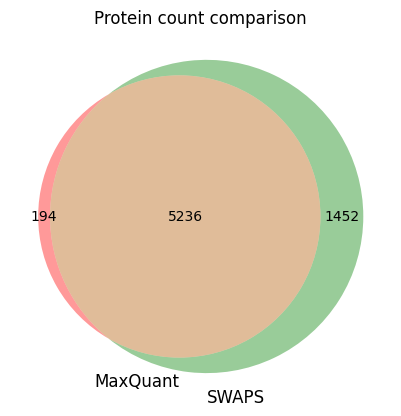

In [182]:
from matplotlib_venn import venn2

venn2(
    subsets=(len(mq_only_protein), len(swaps_only_protein), len(both)),
    set_labels=("MaxQuant", "SWAPS"),
)
plt.title("Protein count comparison")

In [186]:
swap_proteins_count["source"] = "MQ and SWAPS"
swap_proteins_count.loc[
    swap_proteins_count["Protein"].isin(swaps_only_protein), "source"
] = "SWAPS only"

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Count', ylabel='Count'>

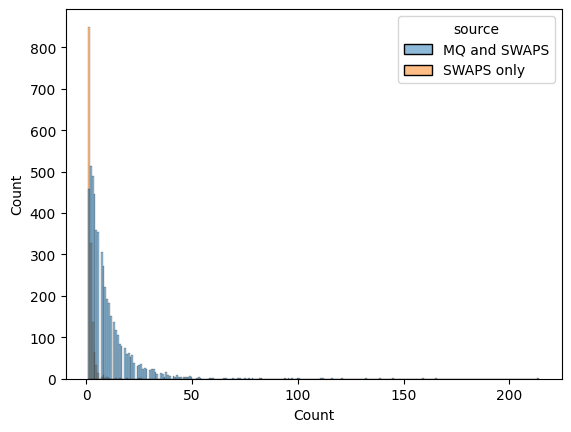

In [193]:
import seaborn as sns

sns.histplot(data=swap_proteins_count, x="Count", hue="source", common_norm=True)

<Axes: >

1.8608815426997245

Count
1     850
2     327
3     137
4      65
5      33
6      15
8       8
7       5
10      3
14      2
9       2
16      1
26      1
25      1
19      1
11      1
Name: count, dtype: int64

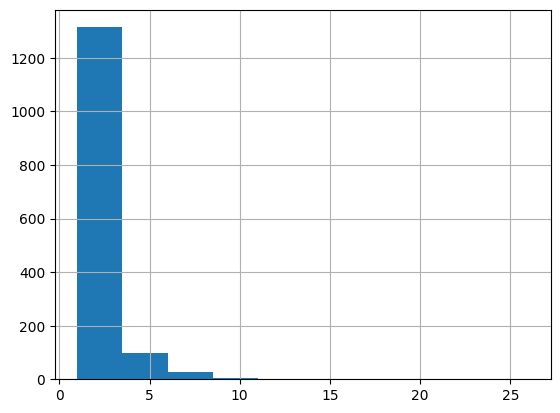

In [197]:
swap_proteins_count.loc[
    swap_proteins_count["Protein"].isin(swaps_only_protein), "Count"
].hist()
swap_proteins_count.loc[
    (swap_proteins_count["Protein"].isin(swaps_only_protein))
    & (swap_proteins_count["Count"] > 0),
    "Count",
].mean()
swap_proteins_count.loc[
    (swap_proteins_count["Protein"].isin(swaps_only_protein))
    & (swap_proteins_count["Count"] > 0),
    "Count",
].value_counts()

<Axes: >

9.756875477463712

Count
2      514
3      490
1      459
4      447
5      358
      ... 
73       1
101      1
145      1
65       1
66       1
Name: count, Length: 81, dtype: int64

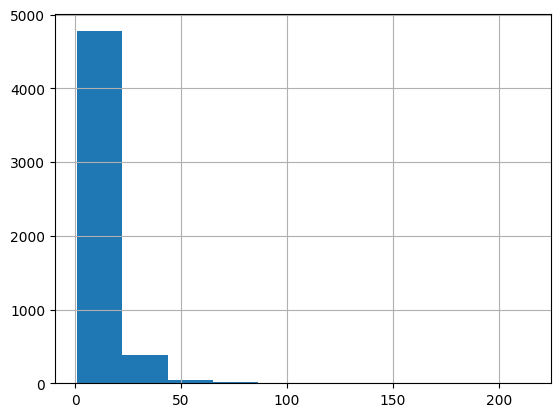

In [196]:
swap_proteins_count.loc[
    ~swap_proteins_count["Protein"].isin(swaps_only_protein), "Count"
].hist()
swap_proteins_count.loc[
    (~swap_proteins_count["Protein"].isin(swaps_only_protein))
    & (swap_proteins_count["Count"] > 0),
    "Count",
].mean()
swap_proteins_count.loc[
    (~swap_proteins_count["Protein"].isin(swaps_only_protein))
    & (swap_proteins_count["Count"] > 0),
    "Count",
].value_counts()

In [ ]:
exp_protein_count["Count"].sum()

# Full set result analysis

In [28]:
pept_act_sum_ps = pd.read_csv(
    os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "pept_act_sum_ps.csv")
)

In [29]:
pept_act_sum_ps_full = pd.merge(
    left=pept_act_sum_ps,
    right=maxquant_result_ref[["mz_rank", "pept_batch_idx"]],
    on=["mz_rank"],
)

In [30]:
%autoreload 2
from peak_detection_2d.utils import compete_target_decoy_pair

pept_act_sum_ps_full, pept_act_sum_ps_full_tdc = compete_target_decoy_pair(
    pept_act_sum_ps, maxquant_result_ref, 
    #filter_dict={"log_sum_intensity": [1, 100]}
)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-11 14:52:38,431 - peak_detection_2d.utils - INFO - FDR after TDC: (Decoy
False    72748
True     16649
Name: count, dtype: int64, 0.22885852532028372)


## Full set before target decoy competetion

In [31]:
from peak_detection_2d.utils import calc_fdr_given_thres

calc_fdr_given_thres(pept_act_sum_ps_full)

(Decoy
 False    89397
 True     89397
 Name: count, dtype: int64,
 1.0)

In [60]:
from peak_detection_2d.utils import plot_target_decoy_distr

plot_target_decoy_distr(
    pept_act_sum_ps_full,
    threshold=None,
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset",
    main_plot_type="scatter",
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/plot.py:346: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(


In [61]:
from peak_detection_2d.utils import plot_roc_auc

plot_roc_auc(
    pept_act_sum_ps_full,
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset",
    # filter_dict={"log_sum_intensity": [2, 100]}
)

0.6112928391543656

In [44]:
pept_act_sum_ps_ref = pd.merge(
    left=maxquant_result_ref.loc[maxquant_result_ref["source"] == "ref", "mz_rank"],
    right=pept_act_sum_ps_full_tdc,
    how="inner",
)
pept_act_sum_ps_both = pd.merge(
    left=maxquant_result_ref.loc[maxquant_result_ref["source"] == "both", "mz_rank"],
    right=pept_act_sum_ps_full_tdc,
    how="inner",
)
# pept_act_sum_ps_exp = pd.merge(
#     left=maxquant_result_ref.loc[maxquant_result_ref["source"] == "exp", "mz_rank"],
#     right=pept_act_sum_ps_full,
#     how="inner",
# )
pept_act_sum_ps_exp = pd.merge(
    left=maxquant_result_ref.loc[maxquant_result_ref["source"] != "ref", "mz_rank"],
    right=pept_act_sum_ps_full_tdc,
    how="inner",
)

2024-09-11 15:12:27,023 - peak_detection_2d.utils - INFO - Number of entries before filtering: 52929
2024-09-11 15:12:27,026 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [2, 100]: 45701


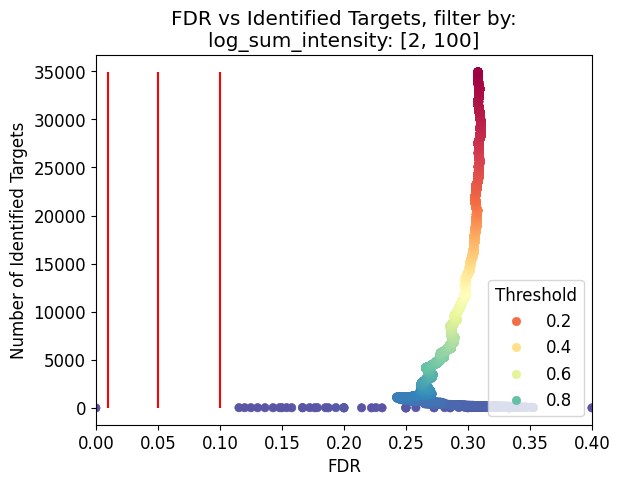

In [53]:
from peak_detection_2d.utils import calc_fdr_and_thres

ref_fdr_thres = calc_fdr_and_thres(
    pept_act_sum_ps_ref,
    score_col="target_decoy_score",
    return_plot=True,
    filter_dict={"log_sum_intensity": [2, 100]},
    xlim=(0, 0.4),
)

In [54]:
def report_decoy_type(df, isolated_decoys):
    print(df["Decoy"].value_counts())
    print(df.loc[df["Decoy"], "mz_rank"].isin(isolated_decoys).sum())


report_decoy_type(df=ref_fdr_thres, isolated_decoys=isolated_decoys)

Decoy
False    34935
True     10766
Name: count, dtype: int64
2758


2024-09-11 15:13:00,221 - peak_detection_2d.utils - INFO - Number of entries before filtering: 36468
2024-09-11 15:13:00,224 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [2, 100]: 35458


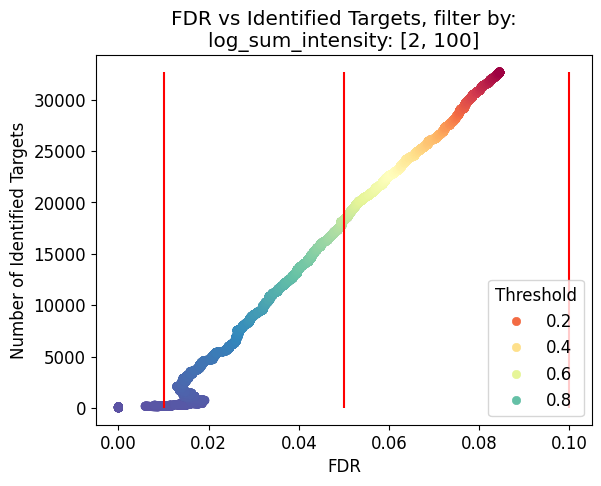

Decoy
False    32695
True      2763
Name: count, dtype: int64
771


In [55]:
exp_fdr_thres = calc_fdr_and_thres(
    pept_act_sum_ps_exp,
    score_col="target_decoy_score",
    return_plot=True,
    filter_dict={"log_sum_intensity": [2, 100]},
)
report_decoy_type(df=exp_fdr_thres, isolated_decoys=isolated_decoys)

In [63]:
%autoreload 2
from peak_detection_2d.utils import plot_roc_auc
plot_roc_auc(
    pred_df_list=[pept_act_sum_ps_full, pept_act_sum_ps_ref, pept_act_sum_ps_both],
    color_list=["blue", "green", "orange"],
    label_list=["fullset", "ref full pred", "exp 30-min"],
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset_all_sources",
    # filter_dict={"log_sum_intensity": [2, 100]}
)

0.8594536216587714

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

<Axes: xlabel='target_decoy_score', ylabel='Count'>

Text(0.5, 1.0, 'ref full pred')

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3

<Axes: xlabel='target_decoy_score', ylabel='Count'>

Text(0.5, 1.0, 'exp 30-min')

Text(0.5, 0, 'Target-Decoy Score')

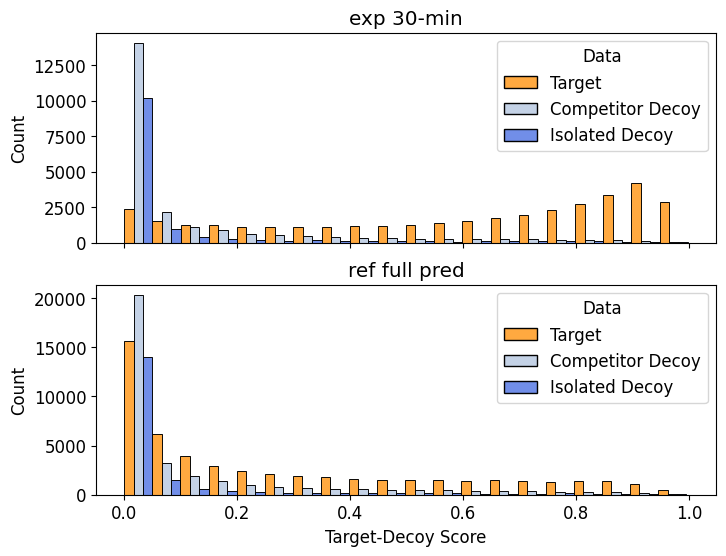

In [35]:
from turtle import title
import matplotlib.pyplot as plt
import seaborn as sns

pept_act_sum_ps_full = pd.merge(
    left=maxquant_result_ref[["mz_rank", "source"]],
    right=pept_act_sum_ps_full,
    how="inner",
)
pept_act_sum_ps_full["Data"] = "Target"
pept_act_sum_ps_full.loc[pept_act_sum_ps_full["Decoy"], "Data"] = "Competitor Decoy"
pept_act_sum_ps_full.loc[
    pept_act_sum_ps_full["mz_rank"].isin(isolated_decoys), "Data"
] = "Isolated Decoy"

# pept_act_sum_ps_full.loc[pept_act_sum_ps_full["Decoy"], "Data"] = "Decoy"
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
plt.rc("font", size=12)  # Set the default font size for all text elements
sns.histplot(
    pept_act_sum_ps_full.loc[pept_act_sum_ps_full["source"] == "ref"],
    x="target_decoy_score",
    hue="Data",
    fill=True,
    hue_order=["Target", "Competitor Decoy", "Isolated Decoy"],
    ax=axs[1],
    common_norm=True,
    bins=20,
    multiple="dodge",
    palette={
        "Target": "darkorange",
        "Competitor Decoy": "lightsteelblue",
        "Isolated Decoy": "royalblue",
    },
    # title="ref 120-min",
)
axs[1].set_title("ref full pred")
sns.histplot(
    pept_act_sum_ps_full.loc[pept_act_sum_ps_full["source"] != "ref"],
    x="target_decoy_score",
    hue="Data",
    fill=True,
    hue_order=["Target", "Competitor Decoy", "Isolated Decoy"],
    common_norm=True,
    palette={
        "Target": "darkorange",
        "Competitor Decoy": "lightsteelblue",
        "Isolated Decoy": "royalblue",
    },
    ax=axs[0],
    bins=20,
    multiple="dodge",
    # title="exp 30-min",
)
axs[0].set_title("exp 30-min")

plt.xlabel("Target-Decoy Score")
plt.savefig(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "results",
        "target_decoy_score_exp_and_ref_hist.png",
    ),
    dpi=300,
    bbox_inches="tight",
)
# # Customize the legend labels
# handles, labels = ax.get_legend_handles_labels()
# # custom_cmap = ListedColormap(["#FF5733", "#33FF57"])  # Custom colors
# custom_labels = ["Targets", "Decoys"]  # Custom label names
# ax.legend(handles=handles, labels=custom_labels, loc="upper right")

In [66]:
from peak_detection_2d.utils import calc_fdr_and_thres

pept_act_sum_ps_full_new = calc_fdr_and_thres(
    pept_act_sum_ps_full,
    score_col="target_decoy_score",
    filter_dict={"log_sum_intensity": [2, 100]},
    return_plot=True,
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset",
)

2024-09-05 09:30:31,817 - peak_detection_2d.utils - INFO - Number of entries before filtering: 283473


2024-09-05 09:30:31,825 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [2, 100]: 148408


In [67]:
pept_act_sum_ps_full_new.to_csv(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "pept_act_sum_ps_full_fdr_thres.csv"
    )
)

## Full set after target decoy competetion

In [68]:
from peak_detection_2d.utils import calc_fdr_given_thres

calc_fdr_given_thres(pept_act_sum_ps_full_tdc)

(Decoy
 False    88828
 True     52911
 Name: count, dtype: int64,
 0.5956567748908002)

In [69]:
plot_target_decoy_distr(
    pept_act_sum_ps_full_tdc,
    # threshold=(0.5, 1),
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset_tdc",
    main_plot_type="scatter",
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


In [70]:
plot_roc_auc(
    pept_act_sum_ps_full_tdc,
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset_tdc",
    # filter_dict={"log_sum_intensity": [2, 100]}
)

0.6274388922137127

In [71]:
%autoreload 2
from peak_detection_2d.utils import calc_fdr_and_thres
pept_act_sum_ps_full_tdc_new = calc_fdr_and_thres(
    pept_act_sum_ps_full_tdc,
    score_col="target_decoy_score",
    filter_dict={"log_sum_intensity": [2, 100]},
    return_plot=True,
    save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset_tdc",
)

2024-09-05 09:31:39,742 - peak_detection_2d.utils - INFO - Number of entries before filtering: 141739
2024-09-05 09:31:39,747 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [2, 100]: 95026


In [72]:
pept_act_sum_ps_full_tdc_new.to_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    ),
    index=False,
)

# Result Analysis (Figure 4)

In [24]:
cfg.MQ_EXP_PATH

'/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined/txt/evidence.txt'

In [122]:
maxquant_result_exp = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/tims_ramp_time/combined_30min_gradient/txt/evidence.txt",
    sep="\t",
    low_memory=False,
)
mq_exp_100ms = maxquant_result_exp[
    maxquant_result_exp["Raw file"]
    == "Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078"
]
mq_exp_120ms = maxquant_result_exp[
    maxquant_result_exp["Raw file"]
    == "Hela2ug_lowflow_30min_1to37to42_NCE29to59_120ms7R_RA2_1_2082"
]

In [29]:
maxquant_result_exp["Raw file"].unique()

array(['Hela2ug_lowflow_30min_1to37to42_NCE29to59_140ms7R_RA2_1_2086',
       'Hela2ug_lowflow_30min_1to37to42_NCE29to59_100ms7R_RA2_1_2078',
       'Hela2ug_lowflow_30min_1to37to42_NCE29to59_120ms7R_RA2_1_2082',
       'Hela2ug_lowflow_30min_1to37to42_NCE29to59_160ms7R_RA2_1_2091',
       'Hela2ug_lowflow_30min_1to37to42_NCE29to59_80ms7R_RA2_1_2075'],
      dtype=object)

In [33]:
mq_HYE = pd.read_csv(
    "/cmnfs/proj/ORIGINS/data/species_mix/DDA/txt_HYE_5ug/evidence.txt",
    sep="\t",
    low_memory=False,
)
mq_HYE["Raw file"].unique()

array(['MixB_5ug_30min_7R_R1_RA1_1_5134',
       'MixA_5ug_30min_7R_R1_RA1_1_5133',
       'MixA_5ug_30min_7R_R2_RA1_1_5135',
       'MixA_5ug_30min_7R_R3_RA1_1_5137',
       'MixA_5ug_30min_7R_R4_RA1_1_5139',
       'MixB_5ug_30min_7R_R2_RA1_1_5136',
       'MixB_5ug_30min_7R_R3_RA1_1_5138',
       'MixB_5ug_30min_7R_R4_RA1_1_5140'], dtype=object)

In [121]:
mq_HYE_5137 = mq_HYE[mq_HYE["Raw file"] == "MixA_5ug_30min_7R_R3_RA1_1_5137"]
mq_HYE_5134 = mq_HYE[mq_HYE["Raw file"] == "MixB_5ug_30min_7R_R1_RA1_1_5134"]

NameError: name 'mq_HYE' is not defined

In [41]:
col_to_compare = ["Modified sequence", "Charge", "Retention time"]
compare_rt = pd.merge(
    mq_HYE_5137[col_to_compare],
    mq_HYE_5134[col_to_compare],
    on=["Modified sequence", "Charge"],
    suffixes=("_100ms", "_120ms"),
)

In [42]:
from utils.metrics import RT_metrics

rt_eval = RT_metrics(
    RT_obs=compare_rt["Retention time_100ms"],
    RT_pred=compare_rt["Retention time_120ms"],
)
rt_eval.CalcDeltaRTwidth()

0.022000000000001574

In [ ]:
maxquant_result_exp = maxquant_result_exp.loc[
    maxquant_result_exp["Raw file"].isin(cfg.FILTER_EXP_BY_RAW_FILE),
    :,
]

In [33]:
ps_exp_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir)
act_dir = os.path.join(cfg.RESULT_PATH, "results", "activation")

<Axes: >

<Axes: >

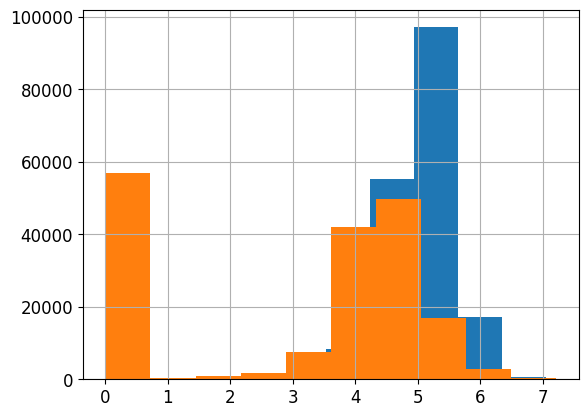

In [106]:
pept_act_sum_df = pd.read_csv(os.path.join(act_dir, "pept_act_sum.csv"))
pept_act_sum_df["log_sum_intensity"] = np.log10(pept_act_sum_df["pept_act_sum"] + 1)
pept_act_sum_df["log_sum_intensity"].hist()
pept_act_sum_ps = pd.read_csv(os.path.join(ps_exp_dir, "pept_act_sum_ps.csv"))
pept_act_sum_ps["log_sum_intensity"] = np.log10(pept_act_sum_ps["sum_intensity"] + 1)
pept_act_sum_ps["log_sum_intensity"].hist()

In [251]:
eval_dir = os.path.join(cfg.RESULT_PATH, "results", "evaluation")
os.makedirs(eval_dir, exist_ok=True)
act_dir = os.path.join(cfg.RESULT_PATH, "results", "activation")
pept_act_sum_df = pd.read_csv(os.path.join(act_dir, "pept_act_sum.csv"))
# TODO: fix im filter config
if cfg.RESULT_ANALYSIS.POST_PROCESSING.FILTER_BY_IM:
    pept_act_sum_filter_by_im_df = pd.read_csv(
        os.path.join(act_dir, "pept_act_sum_filter_by_im.csv")
    )
    pept_act_sum_filter_by_im_df = pept_act_sum_filter_by_im_df.rename(
        {"sum_intensity": "sum_intensity_filter_by_im"}, axis=1
    )
    pept_act_sum_df = pd.merge(
        left=pept_act_sum_df,
        right=pept_act_sum_filter_by_im_df,
        on=["mz_rank"],
        how="left",
        suffixes=("", "_filter_by_im"),
    )

if cfg.PEAK_SELECTION.ENABLE:
    pept_act_sum_ps = pd.read_csv(
        os.path.join(ps_exp_dir, "pept_act_sum_ps_full_tdc_fdr_thres.csv")
    )
    pept_act_sum_ps = pept_act_sum_ps.rename(
        {"sum_intensity": "sum_intensity_ps"}, axis=1
    )
    # pept_act_sum_df = pd.merge(
    #     left=pept_act_sum_df,
    #     right=pept_act_sum_ps,
    #     on=["mz_rank"],
    #     how="left",
    #     suffixes=("", "_ps"),
    # )
    eval_dir = os.path.join(ps_exp_dir, "results", "evaluation")

### Result Plots

In [266]:
10887 / (10887 + 25581)

0.2985357025337282

In [267]:
219 / (5415 + 219)

0.03887113951011715

# Dev

## Generate reverse sequence, eval RT and IM pred diff

In [272]:
def reverse_seq(seq):
    middle_seq = seq[1:-1]
    return seq[0] + middle_seq[::-1] + seq[-1]


maxquant_result_ref_target = maxquant_result_ref.loc[~maxquant_result_ref["Decoy"]]
maxquant_result_ref_decoy_reverse = maxquant_result_ref_target.copy()
maxquant_result_ref_decoy_reverse["Sequence"] = maxquant_result_ref_target[
    "Sequence"
].apply(reverse_seq)

In [281]:
maxquant_result_ref_decoy_reverse = maxquant_result_ref_decoy_reverse.loc[
    maxquant_result_ref_decoy_reverse["Modifications"] == "Unmodified"
]
maxquant_result_ref_decoy_reverse["Modified sequence"] = (
    "_" + maxquant_result_ref_decoy_reverse["Sequence"] + "_"
)
construct_dict_dir = os.path.join(cfg.RESULT_PATH, "construct_dict_decoy_reverse")
os.makedirs(construct_dict_dir, exist_ok=True)
dict_path = os.path.join(construct_dict_dir, "maxquant_dict_decoy_for_pred.txt")
maxquant_result_ref_decoy_reverse.to_csv(
    dict_path,
    sep="\t",
    index=False,
)

In [302]:
maxquant_result_ref_decoy_reverse.columns
maxquant_result_ref_decoy_reverse.drop(labels=["rt_pred"], axis=1, inplace=True)

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'IsoMZ', 'IsoAbundance', 'mz_rank', 'mz_bin', 'mz_length',
       'pept_batch_idx', 'rt_start_bin', 'rt_end_bin', 'rt_center_bin',
       'mobility_pred'],
      dtype='object', length=115)

KeyError: "['rt_pred'] not found in axis"

In [303]:
%autoreload 2
from prepare_dict.prepare_dict import dict_add_alpha_pept_pred

# gpu_count = torch.cuda.device_count()
# match gpu_count:
#     case 0:
#         device = "cpu"
#         Logger.info("No GPU available, using CPU")
#     case 1:
#         device = "cuda"
#         Logger.info("Using 1 GPU, device is %s", device)
#     case _:
#         device = "gpu"
#         Logger.info("Using multiple GPUs, device is %s", device)
# add rt pred

maxquant_result_ref_decoy_reverse = dict_add_alpha_pept_pred(
    model_path="/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240826_175342_706954/construct_dict/RT_transfer_learn/rt_model",
    pept_property="rt",
    dict_for_pred_path=dict_path,
    maxquant_dict=maxquant_result_ref_decoy_reverse,
    lc_grad=28.17,
    device="cpu",
)

# add im pred

2024-09-06 15:59:15> Device: cpu
2024-09-06 15:59:15> dict size: (87378, 115)
2024-09-06 15:59:18> dict_for_pred size: (87378, 18)
2024-09-06 15:59:48> Columns in predict_df: Index(['sequence', 'charge', 'rt', 'ccs', 'mobility', 'scan_num', 'raw_name',
       'precursor_mz', 'score', 'proteins', 'genes', 'decoy', 'intensity',
       'spec_idx', 'mods', 'mod_sites', 'nAA', 'rt_norm', 'rt_pred',
       'rt_pred_norm'],
      dtype='object')
2024-09-06 15:59:48> Columns in predict_df: Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'pept_batch_idx', 'rt_start_bin', 'rt_end_bin', 'rt_center_bin',
       'mobility_pred', 'sequence', 'charge', 'scan_num', 'raw_name',
       'rt_pred'],
      dtype='object', length=120)
2024-09-06 15:59:48> dict size after dropping empty prediction: (87378, 116)


In [285]:
maxquant_result_ref_decoy_reverse = dict_add_alpha_pept_pred(
    model_path="/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/full_pred_libaray_100ms_20240904_155157_142605/construct_dict/IM_transfer_learn/mobility_model",
    pept_property="mobility",
    dict_for_pred_path=dict_path,
    maxquant_dict=maxquant_result_ref_decoy_reverse,
    lc_grad=28.17,
    device="cpu",
)

2024-09-06 15:48:54> Device: cpu
2024-09-06 15:48:54> dict size: (87378, 115)
2024-09-06 15:48:57> dict_for_pred size: (87378, 18)
2024-09-06 15:49:27> Number of entries with empty prediction: 0
2024-09-06 15:49:28> dict size after dropping empty prediction: (87378, 116)


In [307]:
maxquant_td_compare = pd.merge(
    left=maxquant_result_ref_target[["mz_rank", "rt_pred", "1/K0"]],
    right=maxquant_result_ref_decoy_reverse[["mz_rank", "rt_pred", "mobility_pred"]],
    on=["mz_rank"],
    suffixes=("_target", "_decoy_reverse"),
    how="inner",
)
maxquant_td_compare["rt_diff"] = abs(
    maxquant_td_compare["rt_pred_target"] - maxquant_td_compare["rt_pred_decoy_reverse"]
)
maxquant_td_compare["mobility_diff"] = abs(
    maxquant_td_compare["1/K0"] - maxquant_td_compare["mobility_pred"]
)

In [309]:
maxquant_td_compare["rt_differentaible"] = maxquant_td_compare["rt_diff"] > 0.4
maxquant_td_compare["mobility_differentaible"] = (
    maxquant_td_compare["mobility_diff"] > 0.02
)
maxquant_td_compare["differentaible"] = maxquant_td_compare["rt_differentaible"].astype(
    int
) + maxquant_td_compare["mobility_differentaible"].astype(int)

## Seperated FDR

In [113]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import numpy as np


def calculat_post_prob(pept_act_sum_ps_full_tdc):
    # Example DataFrame with ion scores (replace with your actual data)
    # df = pd.DataFrame({'score': [100, 150, 200, 250, 300]})
    scores = pept_act_sum_ps_full_tdc["target_decoy_score"].values.reshape(
        -1, 1
    )  # Reshape for sklearn

    # Step 1: Fit the Gaussian Mixture Model with 2 components
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(scores)

    # Step 2: Retrieve the parameters of the GMM
    pi_0, pi_1 = gmm.weights_  # Mixing coefficients (pi_0, pi_1)
    mu_0, mu_1 = gmm.means_.flatten()  # Means of the components (f_0 and f_1)
    sigma_0, sigma_1 = np.sqrt(gmm.covariances_).flatten()  # Standard deviations

    # Step 3: Calculate the posterior probability p(s_i) for each ion

    # Calculate the probability density function (PDF) values for each score under f_0 and f_1
    f_0 = norm.pdf(scores.flatten(), mu_0, sigma_0)  # f_0(s)
    f_1 = norm.pdf(scores.flatten(), mu_1, sigma_1)  # f_1(s)

    p_s_i = (pi_0 * f_0) / (pi_0 * f_0 + pi_1 * f_1)
    logging.info(
        "Distribution f0, targets: mu=%.2f, sigma=%.2f, pi=%.2f",
        mu_0,
        sigma_0,
        pi_0,
    )
    logging.info(
        "Distribution f1, decoys: mu=%.2f, sigma=%.2f, pi=%.2f",
        mu_1,
        sigma_1,
        pi_1,
    )

    # scores_target = pept_act_sum_ps_full_tdc.loc[
    #     ~pept_act_sum_ps_full_tdc["Decoy"], "target_decoy_score"
    # ].values
    # scores_decoy = pept_act_sum_ps_full_tdc.loc[
    #     pept_act_sum_ps_full_tdc["Decoy"], "target_decoy_score"
    # ].values
    # gmm_target = GaussianMixture(n_components=1, random_state=42).fit(
    #     scores_target.reshape(-1, 1)
    # )
    # gmm_decoy = GaussianMixture(n_components=1, random_state=42).fit(
    #     scores_decoy.reshape(-1, 1)
    # )
    # pi_target, pi_decoy = (
    #     pept_act_sum_ps_full_tdc[~pept_act_sum_ps_full_tdc["Decoy"]].shape[0]
    #     / pept_act_sum_ps_full_tdc.shape[0],
    #     pept_act_sum_ps_full_tdc[pept_act_sum_ps_full_tdc["Decoy"]].shape[0]
    #     / pept_act_sum_ps_full_tdc.shape[0],
    # )
    # f_target = gmm_target.score_samples(scores.reshape(-1, 1))
    # f_decoy = gmm_decoy.score_samples(scores.reshape(-1, 1))
    # # Compute the posterior probability p(s_i) using Equation 4
    # p_s_i = (pi_target * f_target) / (pi_target * f_target + pi_decoy * f_decoy)
    # # # Output the results
    # # print(df[['score', 'posterior_probability']])
    # logging.info(
    #     "Distribution f0, targets: mu=%.2f, sigma=%.2f, pi=%.2f",
    #     gmm_target.means_[0][0],
    #     np.sqrt(gmm_target.covariances_[0][0][0]),
    #     pi_target,
    # )
    # logging.info(
    #     "Distribution f1, decoys: mu=%.2f, sigma=%.2f, pi=%.2f",
    #     gmm_decoy.means_[0][0],
    #     np.sqrt(gmm_decoy.covariances_[0][0][0]),
    #     pi_decoy,
    # )
    # Add the posterior probabilities to the dataframe
    pept_act_sum_ps_full_tdc["posterior_probability"] = p_s_i

    return pept_act_sum_ps_full_tdc

In [114]:
import pandas as pd


def calculate_fdr(df, t):
    # Filter the rows where score is greater than or equal to the threshold t
    df_filtered_targets = df.loc[(df["target_decoy_score"] >= t) & (df["Decoy"] == 0)]
    df_filtered_score = df[df["target_decoy_score"] >= t]
    # Calculate FDR
    numerator = (
        1 - df_filtered_targets["posterior_probability"]
    ).sum()  # Sum of (1 - p(si))
    denominator = len(df_filtered_targets)  # Number of ions with score >= t

    # Avoid division by zero
    if denominator == 0:
        return 0

    fdr = numerator / denominator
    return fdr

In [115]:
test = calculat_post_prob(pred_df_new)
calculate_fdr(test, 0.1)
calculate_fdr(test, 0.2)
calculate_fdr(test, 0.3)
calculate_fdr(test, 0.4)
calculate_fdr(test, 0.5)
calculate_fdr(test, 0.6)
calculate_fdr(test, 0.7)
calculate_fdr(test, 0.8)
calculate_fdr(test, 0.9)

2024-09-06 12:37:19> Distribution f0, targets: mu=0.75, sigma=0.17, pi=0.51
2024-09-06 12:37:19> Distribution f1, decoys: mu=0.14, sigma=0.12, pi=0.49


0.26952076856189733

0.18209248697333189

0.1015720168403681

0.028603188101584683

0.002266328495745616

0.00010236930712945285

3.924521087973427e-06

1.4095940550176495e-07

5.577589577809187e-09

## Proper competition

In [6]:
maxquant_result_ref["rt_start_bin"] = np.round(
    maxquant_result_ref["RT_search_left"], decimals=0
)
maxquant_result_ref["rt_end_bin"] = np.round(
    maxquant_result_ref["RT_search_right"], decimals=0
)
maxquant_result_ref["rt_center_bin"] = np.round(
    maxquant_result_ref["RT_search_center"], decimals=0
)

In [14]:
# maxquant_result_exp = dict_add_mz_bin(maxquant_result_exp)
mzbin_td_counts = (
    maxquant_result_ref.groupby(["mz_bin"])
    .agg(
        {
            "RT_search_left": "min",
            "RT_search_right": "max",
            "IM_search_idx_left": "min",
            "IM_search_idx_right": "max",
            "1/K0": "mean",
            # "1/K0": "std",
            "id": "count",
        }
    )
    .reset_index()
)
mzbin_td_counts["rt_range"] = (
    mzbin_td_counts["RT_search_right"] - mzbin_td_counts["RT_search_left"]
)
mzbin_td_counts["im_idx_range"] = (
    mzbin_td_counts["IM_search_idx_right"] - mzbin_td_counts["IM_search_idx_left"]
)

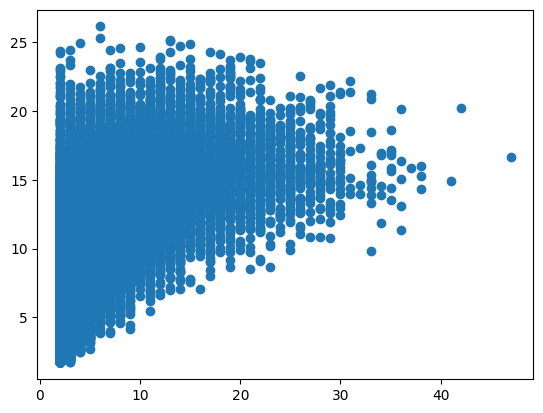

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
mzbin_td_counts_filtered = mzbin_td_counts.loc[mzbin_td_counts["id"] > 1]
plt.scatter(mzbin_td_counts_filtered["id"], mzbin_td_counts_filtered["rt_range"])
plt.show()

#### Get number of isolated decoys

In [79]:
pept_act_sum_ps_tdc["Decoy"].value_counts()
pept_act_sum_ps_tdc = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    )
)
maxquant_result_ref_tdc = pd.merge(
    left=pept_act_sum_ps_tdc, right=maxquant_result_ref, on=["mz_rank", "Decoy"]
)
%autoreload 2
from postprocessing.fdr import generate_signal_compete_pairs

signal_compete_tdc = generate_signal_compete_pairs(
    maxquant_dict=maxquant_result_ref_tdc, groupby_columns="mz_bin"
)
signal_compete_all = generate_signal_compete_pairs(
    maxquant_dict=maxquant_result_ref, groupby_columns="mz_bin"
)
decoy_mz_ranks = set(maxquant_result_ref.loc[maxquant_result_ref["Decoy"], "mz_rank"])

from postprocessing.fdr import get_isolated_decoys_from_pairs

isolated_decoys_set_pairs_tdc = get_isolated_decoys_from_pairs(
    result=signal_compete_tdc, decoy_mz_ranks=decoy_mz_ranks
)
isolated_decoys_set_pairs_all = get_isolated_decoys_from_pairs(
    result=signal_compete_all, decoy_mz_ranks=decoy_mz_ranks
)

from postprocessing.fdr import get_isolated_decoy_from_mzbins

isolated_decoys_mzbins_set = get_isolated_decoy_from_mzbins(
    maxquant_result_ref=maxquant_result_ref,
)

Decoy
False    67770
True     13591
Name: count, dtype: int64

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


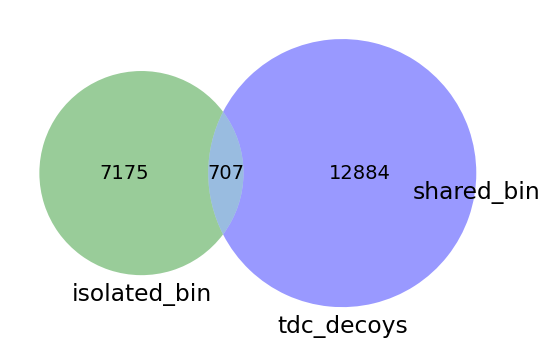

In [89]:
from utils.plot import plot_venn3

plot_venn3(
    set1=isolated_decoys_set_pairs_all,
    set2=isolated_decoys_mzbins_set,
    set3=set(
        maxquant_result_ref_tdc.loc[maxquant_result_ref_tdc["Decoy"], "mz_rank"].values
    ),
    label1="shared_bin",
    label2="isolated_bin",
    label3="tdc_decoys",
)

In [13]:
isolated_decoys_all = isolated_decoys_set_pairs_tdc.union(isolated_decoys_mzbins_set)

#### Signal competition

In [14]:
%autoreload 2
from postprocessing.compete_signal import compete_candidates_for_signal

# pept_act_sum_ps_all = pd.read_csv(
#     os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "pept_act_sum_ps.csv")
# )
pept_act_sum_ps_tdc_all, result_after_compete, result_filtered = compete_candidates_for_signal(
    result=signal_compete_tdc, pept_act_sum_ps=pept_act_sum_ps_tdc, log_sum_intensity_thres=1, delta_log_sum_intensity_thres=0.01
)

2024-09-11 15:43:56,306 - postprocessing.compete_signal - INFO - Number of pairs after filtering rt and im distance: 37640
2024-09-11 15:43:56,355 - postprocessing.compete_signal - INFO - Number of pairs after filtering by log sum intensity: 37640
2024-09-11 15:43:56,357 - postprocessing.compete_signal - INFO - Number of pairs with delta log intensity < 0.5: 691


/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/compete_signal.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_filtered_no_low_int_and_only_close_int[["loser", "winner"]] = (
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/compete_signal.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_filtered_no_low_int_and_only_close_int[["loser", "winner"]] = (
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/compete_signal.py:124: FutureWarning: A val

### FDR eval and result analysis

In [109]:
pept_act_sum_ps_full_tdc = pept_act_sum_ps_tdc_all.loc[
    pept_act_sum_ps_tdc_all["competition"] != "loser"
]
pept_act_sum_ps_full_tdc = pept_act_sum_ps_full_tdc.loc[
    pept_act_sum_ps_full_tdc["log_sum_intensity"] >= 2
]
pept_act_sum_ps_full_tdc["Decoy"].value_counts()

Decoy
False    67121
True     13356
Name: count, dtype: int64

In [114]:
pept_act_sum_ps_full_tdc.loc[pept_act_sum_ps_full_tdc["Decoy"], "mz_rank"].isin(
    isolated_decoys_all
).sum()

3527

In [113]:
13356 / 67121
(13356 - 3527) / 67121
3527 / 67121

0.1989839245541634

0.14643703162944532

0.05254689292471805

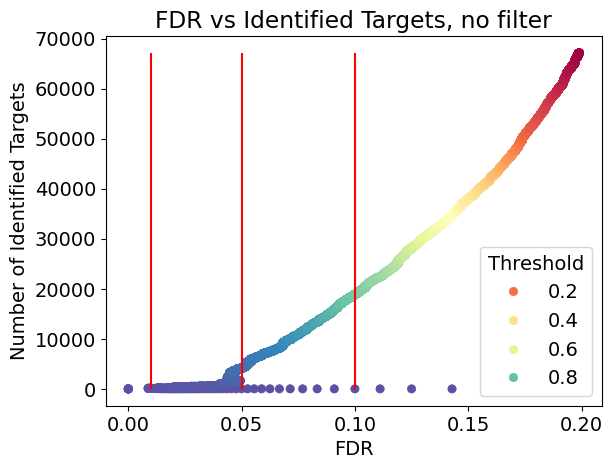

In [115]:
from peak_detection_2d.utils import calc_fdr_and_thres

fdr_no_loser_filter = calc_fdr_and_thres(pept_act_sum_ps_full_tdc, return_plot=True)

In [24]:
pept_act_sum_ps_full_tdc.columns

Index(['Unnamed: 0', 'sum_intensity', 'mz_rank', 'out_score',
       'target_decoy_score', 'Decoy', 'TD pair id', 'log_sum_intensity',
       'Target', 'fdr', 'N_identified_target', 'competition'],
      dtype='object')

In [34]:
from math import inf
from result_analysis.result_analysis import SWAPSResult

pept_act_sum_df = pd.read_csv(
    os.path.join(cfg.RESULT_PATH, "results", "activation", "pept_act_sum.csv")
)
swaps_result = SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_df,
    infer_intensity_col="pept_act_sum",
    fdr_thres=1.0,
    log_sum_intensity_thres=2,
    include_decoys=False,
)

2024-09-11 15:54:56,505 - result_analysis.result_analysis - INFO - Drop na values in pept_act_sum, Pept activation sum entries: 178795
2024-09-11 15:54:56,506 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 178795
2024-09-11 15:54:56,509 - result_analysis.result_analysis - INFO - Number of entries after filtering 178794
2024-09-11 15:54:56,510 - result_analysis.result_analysis - INFO - No decoy entries in the data, using FDR threshold of dictionary 1.0


<Figure size 800x600 with 0 Axes>

2024-09-11 15:56:37,848 - result_analysis.result_analysis - INFO - Number of entries after merging 72936 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'Time_minute_right_ref', 'MS1_frame_idx_right_ref', 'IsoMZ',
       'IsoAbundance', 'mz_rank', 'mz_bin', 'mz_length', 'pept_batch_idx',
       'pept_act_sum', 'log_sum_intensity'],
      dtype='object', length=114)


Data:  Intensity_log pept_act_sum_log , slope =  0.281 , intercept =  3.673 , PearsonR =  0.305 , SpearmanR =  0.282


<Figure size 800x600 with 0 Axes>

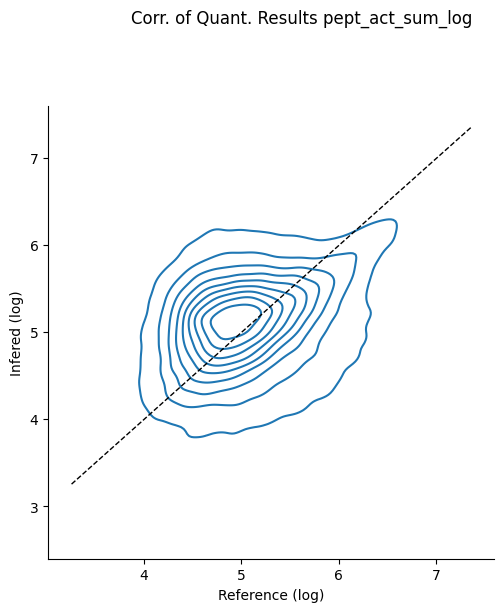

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
swaps_result.plot_intensity_corr(contour=True)

2024-09-11 15:48:53,555 - result_analysis.result_analysis - INFO - Drop na values in sum_intensity, Pept activation sum entries: 80477
2024-09-11 15:48:53,556 - result_analysis.result_analysis - INFO - Filtering the data by the sum of intensity threshold 2, number of entries before filtering 80477
2024-09-11 15:48:53,561 - result_analysis.result_analysis - INFO - Number of entries after filtering 80477
2024-09-11 15:48:53,564 - result_analysis.result_analysis - INFO - FDR threshold is larger than the maximum FDR, set to maximum FDR 0.199
2024-09-11 15:48:53,565 - result_analysis.result_analysis - INFO - Calculating FDR results after filter...
2024-09-11 15:48:53,568 - peak_detection_2d.utils - INFO - Number of entries before filtering: 80477
2024-09-11 15:48:53,573 - peak_detection_2d.utils - INFO - Number of entries after filtering by log_sum_intensity with condition [0, 100]: 80477


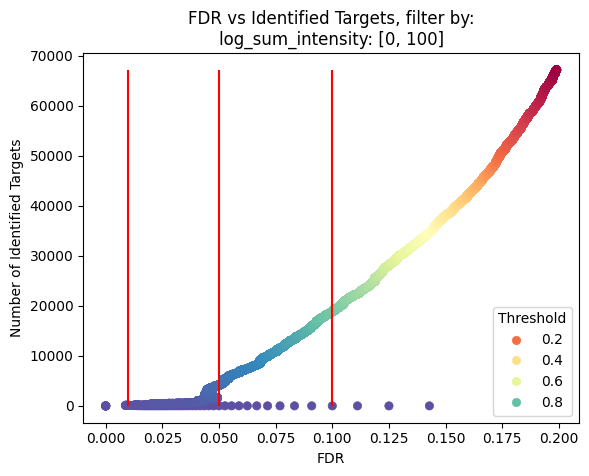

2024-09-11 15:48:56,765 - result_analysis.result_analysis - INFO - Filtering the data by FDR threshold 0.199, number of entries before filtering 80477
2024-09-11 15:48:56,774 - result_analysis.result_analysis - INFO - Score threshold 0.0166004157587719, number of entries after filtering 78897
2024-09-11 15:48:56,775 - result_analysis.result_analysis - INFO - Removing decoy entries, number of entries before filtering 78897
2024-09-11 15:48:56,779 - result_analysis.result_analysis - INFO - Number of entries after filtering 65887
2024-09-11 15:48:57,018 - result_analysis.result_analysis - INFO - Number of entries after merging 32320 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'sum_intensity', 'out_score', 'target_decoy_score', 'Decoy_y',
       'TD pair id_y', 'log_sum_intensity', '

Data:  Intensity_log sum_intensity_log , slope =  0.939 , intercept =  -0.036 , PearsonR =  0.837 , SpearmanR =  0.822


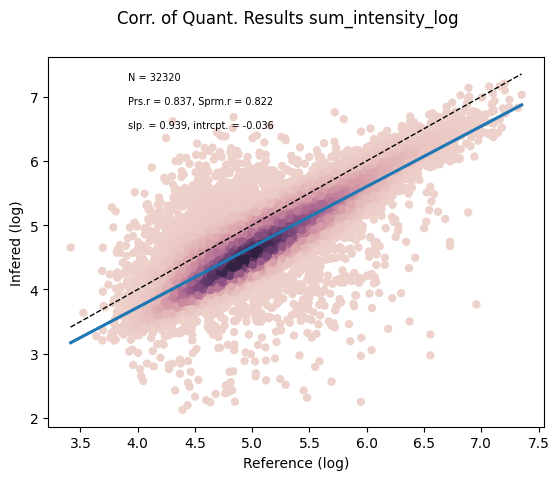

In [25]:
from result_analysis.result_analysis import SWAPSResult

swaps_result = SWAPSResult(
    maxquant_dict=maxquant_result_ref,
    pept_act_sum_df=pept_act_sum_ps_full_tdc,
    infer_intensity_col="sum_intensity",
    fdr_thres=0.2,
    log_sum_intensity_thres=2,
)

2024-09-11 15:51:49,149 - result_analysis.result_analysis - INFO - Number of entries after merging 32320 and columns Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins',
       ...
       'sum_intensity', 'out_score', 'target_decoy_score', 'Decoy_y',
       'TD pair id_y', 'log_sum_intensity', 'Target', 'fdr',
       'N_identified_target', 'competition'],
      dtype='object', length=123)


Data:  Intensity_log sum_intensity_log , slope =  0.939 , intercept =  -0.036 , PearsonR =  0.837 , SpearmanR =  0.822


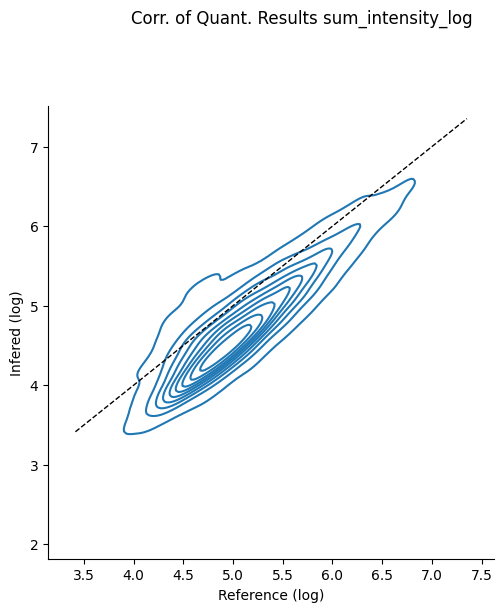

In [29]:
plt.figure(figsize=(8, 6))
swaps_result.plot_intensity_corr(contour=True)

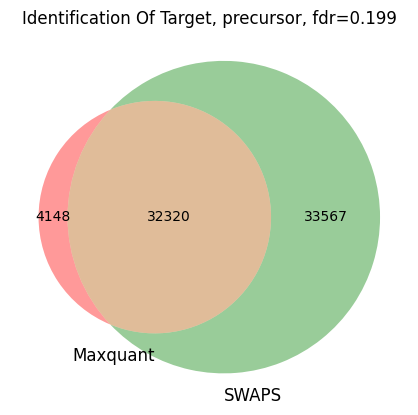

In [26]:
swaps_result.plot_overlap_with_MQ(show_ref=False, level="precursor")

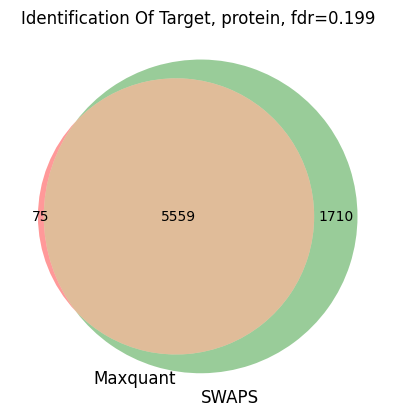

In [27]:
swaps_result.plot_overlap_with_MQ(show_ref=False, level="protein")

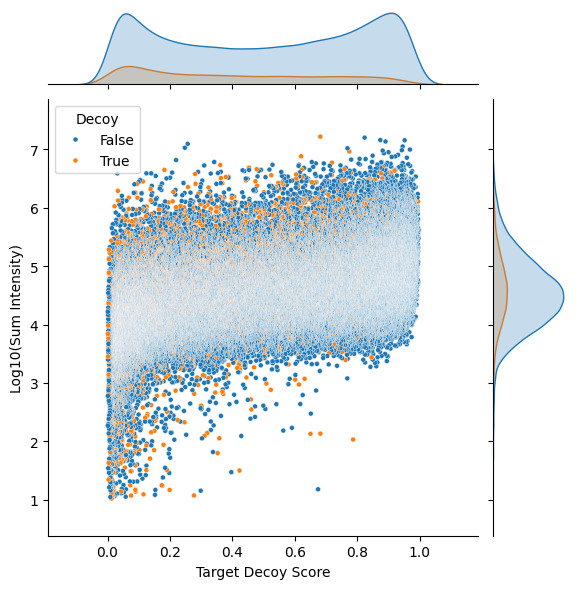

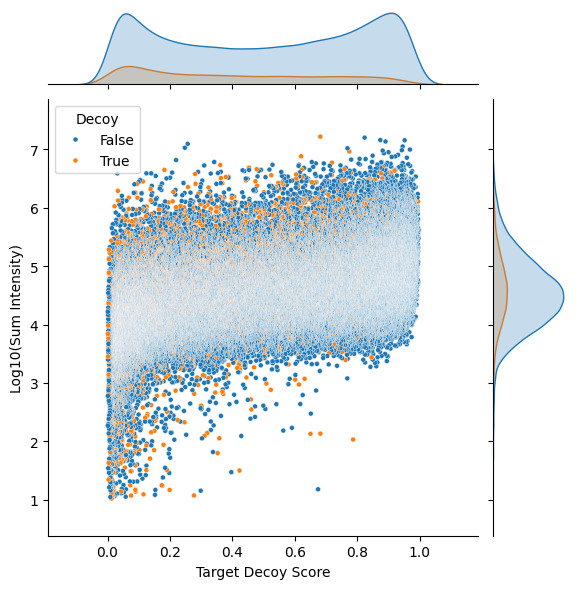

In [44]:
%matplotlib inline
from peak_detection_2d.utils import plot_target_decoy_distr

plot_target_decoy_distr(pept_act_sum_ps_full_tdc)


<Axes: >

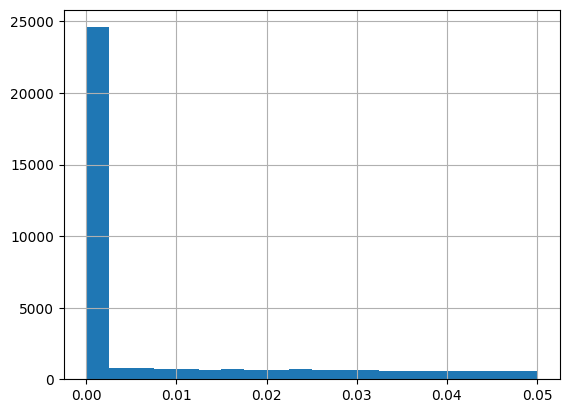

In [46]:
result_filtered.loc[result_filtered["delta_log_sum_intensity"] < 0.05][
    "delta_log_sum_intensity"
].hist(bins=20)

In [47]:
result_after_compete["Decoy_count"].value_counts()
result_after_compete_tdc = result_after_compete.loc[
    result_after_compete["Decoy_count"] == 1
]
from postprocessing.compete_signal import get_target_mz_rank

result_after_compete_tdc["target_mz_rank"] = result_after_compete_tdc.apply(
    get_target_mz_rank, axis=1
)
result_after_compete_tdc = pd.merge(
    left=result_after_compete_tdc,
    right=maxquant_result_ref[["mz_rank", "source"]],
    left_on="target_mz_rank",
    right_on="mz_rank",
)
result_after_compete_tdc_exp = result_after_compete_tdc.loc[
    result_after_compete_tdc["source"] != "ref"
]
result_after_compete_tdc_winner = set(result_after_compete_tdc["winner"]) - set(
    result_after_compete_tdc["loser"]
)

Decoy_count
1    1561
0    1177
2     457
Name: count, dtype: int64

/tmp/ipykernel_378798/1046279344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_after_compete_tdc["target_mz_rank"] = result_after_compete_tdc.apply(


In [48]:
# Number of decoys that are winners
len(result_after_compete_tdc_winner.intersection(decoy_mz_ranks))

476

In [92]:
pept_act_sum_ps_tdc = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        ps_dir,
        "pept_act_sum_ps_full_tdc_fdr_thres.csv",
    )
)

In [50]:
pept_act_sum_ps_all = pd.merge(
    left=pept_act_sum_ps_all,
    right=maxquant_result_ref[["mz_rank", "Decoy"]],
    on=["mz_rank"],
)

In [51]:
pept_act_sum_ps_all.loc[
    pept_act_sum_ps_all["competition"] == "winner", "Decoy"
].value_counts()

Decoy
False    2097
True      872
Name: count, dtype: int64

In [52]:
pept_act_sum_ps_all_no_loser = pept_act_sum_ps_all.loc[
    pept_act_sum_ps_all["competition"] != "loser"
]
# pept_act_sum_ps_all_no_loser = pd.merge(
#     left=pept_act_sum_ps_all_no_loser,
#     right=maxquant_result_ref[["mz_rank", "Decoy"]],
#     on=["mz_rank"],
# )
pept_act_sum_ps_all_no_loser["log_sum_intensity"] = np.log10(
    pept_act_sum_ps_all_no_loser["sum_intensity"] + 1
)
pept_act_sum_ps_all_no_loser["Decoy"].value_counts()

/tmp/ipykernel_378798/1344436282.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pept_act_sum_ps_all_no_loser["log_sum_intensity"] = np.log10(


Decoy
True     87954
False    87770
Name: count, dtype: int64

In [136]:
from peak_detection_2d.utils import compete_target_decoy_pair

pept_act_sum_ps_all_no_loser_full, pept_act_sum_ps_all_no_loser_tdc = (
    compete_target_decoy_pair(pept_act_sum_ps_all_no_loser, maxquant_result_ref)
)

2024-09-06 13:11:07> FDR after TDC: (Decoy
False    54928
True     25967
Name: count, dtype: int64, 0.47274614040198076)


In [57]:
pept_act_sum_ps_all_no_loser_filtered_by_int = pept_act_sum_ps_all_no_loser.loc[
    (pept_act_sum_ps_all_no_loser["log_sum_intensity"] > 2)
    # & (pept_act_sum_ps_all_no_loser["target_decoy_score"] > 0)
]
pept_act_sum_ps_all_no_loser_filtered_by_int["Decoy"].value_counts()

Decoy
False    77163
True     40799
Name: count, dtype: int64

In [60]:
pept_act_sum_ps_all_no_loser_filtered_by_int.loc[
    pept_act_sum_ps_all_no_loser_filtered_by_int["Decoy"], "mz_rank"
].isin(isolated_decoys_all).sum()

11048

In [82]:
def eval_fdr_and_decoy_composition(
    pept_act_sum_df: pd.DataFrame, filter_dict: dict, isolated_decoys_all: set
):
    pept_act_sum_df_filtered = pept_act_sum_df

    for col, value in filter_dict.items():
        assert col in pept_act_sum_df.columns
        f"Column '{col}' not found in pept_act_sum_df"
        pept_act_sum_df_filtered = pept_act_sum_df_filtered.loc[
            (pept_act_sum_df_filtered[col] >= value[0])
            & (pept_act_sum_df_filtered[col] <= value[1])
        ]
    print(pept_act_sum_df_filtered["Decoy"].value_counts(normalize=True))
    print(
        pept_act_sum_df_filtered.loc[pept_act_sum_df_filtered["Decoy"], "mz_rank"]
        .isin(isolated_decoys_all)
        .sum()
    )
    n_targets = (~pept_act_sum_df_filtered["Decoy"]).sum()
    n_decoys = pept_act_sum_df_filtered["Decoy"].sum()
    n_isolated_decoys = (
        pept_act_sum_df_filtered.loc[pept_act_sum_df_filtered["Decoy"], "mz_rank"]
        .isin(isolated_decoys_all)
        .sum()
    )
    logging.info(f"Number of targets: {n_targets}")
    logging.info(f"Number of decoys: {n_decoys}")
    logging.info(f"Number of isolated decoys: {n_isolated_decoys}")

In [74]:
pept_act_sum_ps_all.columns

Index(['sum_intensity', 'mz_rank', 'out_score', 'target_decoy_score',
       'competition', 'Decoy', 'log_sum_intensity'],
      dtype='object')

In [83]:
pept_act_sum_ps_all["log_sum_intensity"] = np.log10(
    pept_act_sum_ps_all["sum_intensity"] + 1
)
eval_fdr_and_decoy_composition(
    pept_act_sum_df=pept_act_sum_ps_all,
    filter_dict={"log_sum_intensity": [2, 100]},
    isolated_decoys_all=isolated_decoys_all,
)

2024-09-08 19:08:55,348 - root - INFO - Number of targets: 78790
2024-09-08 19:08:55,349 - root - INFO - Number of decoys: 42242
2024-09-08 19:08:55,349 - root - INFO - Number of isolated decoys: 11095


Decoy
False    0.650985
True     0.349015
Name: proportion, dtype: float64
11095


In [99]:
eval_fdr_and_decoy_composition(
    pept_act_sum_df=pept_act_sum_ps_all,
    filter_dict={"log_sum_intensity": [2, 100], "target_decoy_score": [0.0001, 1]},
    isolated_decoys_all=isolated_decoys_all,
)

2024-09-08 19:27:42,708 - root - INFO - Number of targets: 78790
2024-09-08 19:27:42,709 - root - INFO - Number of decoys: 42242
2024-09-08 19:27:42,710 - root - INFO - Number of isolated decoys: 11095


Decoy
False    0.650985
True     0.349015
Name: proportion, dtype: float64
11095


In [86]:
eval_fdr_and_decoy_composition(
    pept_act_sum_df=pept_act_sum_ps_all_no_loser,
    filter_dict={"log_sum_intensity": [2, 100]},
    isolated_decoys_all=isolated_decoys_all,
)

2024-09-08 19:09:29,949 - root - INFO - Number of targets: 77163
2024-09-08 19:09:29,950 - root - INFO - Number of decoys: 40799
2024-09-08 19:09:29,950 - root - INFO - Number of isolated decoys: 11048


Decoy
False    0.654134
True     0.345866
Name: proportion, dtype: float64
11048


In [101]:
eval_fdr_and_decoy_composition(
    pept_act_sum_df=pept_act_sum_ps_tdc,
    filter_dict={"log_sum_intensity": [2, 100]},
    isolated_decoys_all=isolated_decoys_all,
)

2024-09-08 19:28:04,439 - root - INFO - Number of targets: 67630
2024-09-08 19:28:04,440 - root - INFO - Number of decoys: 13529
2024-09-08 19:28:04,441 - root - INFO - Number of isolated decoys: 3529


Decoy
False    0.833303
True     0.166697
Name: proportion, dtype: float64
3529


In [102]:
(13529 - 3529) / 67630

0.1478633742422002

#### where is the MQ exp ID lost

In [181]:
mq_exp_rank = maxquant_result_ref.loc[
    (maxquant_result_ref["source"] != "ref") & (maxquant_result_ref["Decoy"] == 0),
    "mz_rank",
].values

In [182]:
pept_act_sum_ps_all_no_loser["mz_rank"].isin(mq_exp_rank).sum()

27211

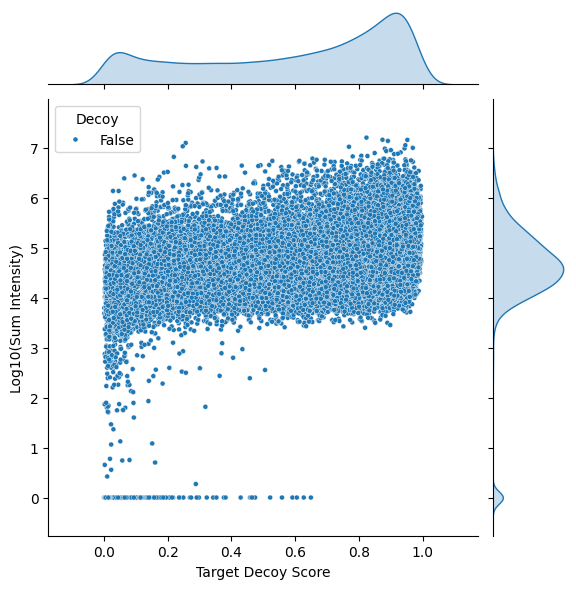

In [183]:
plot_target_decoy_distr(
    pept_act_sum_ps_all[pept_act_sum_ps_all["mz_rank"].isin(mq_exp_rank)],
    # save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset_no_loser",
    main_plot_type="scatter",
)

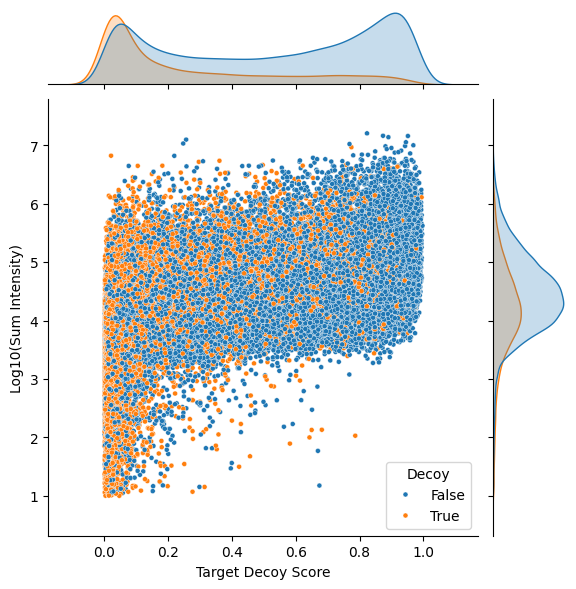

In [165]:
plot_target_decoy_distr(
    pept_act_sum_ps_all_no_loser_filtered_by_int,
    # save_dir=os.path.join(cfg.RESULT_PATH, "peak_selection", ps_dir, "results"),
    dataset_name="fullset_no_loser",
    main_plot_type="scatter",
)

2024-09-06 14:43:03> Number of entries before filtering: 80895
2024-09-06 14:43:03> Number of entries after filtering by log_sum_intensity with condition [1, 100]: 60080


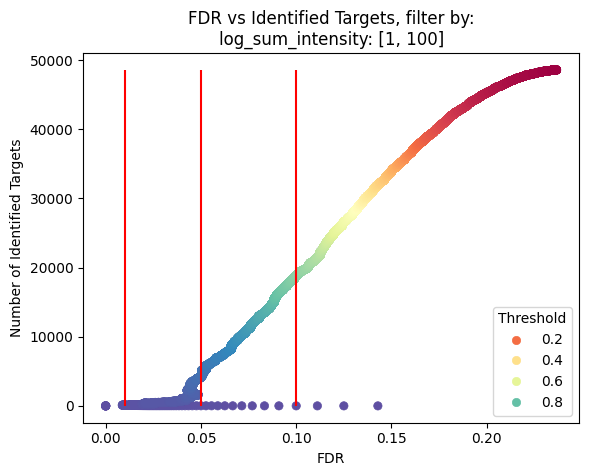

In [214]:
from peak_detection_2d.utils import plot_target_decoy_distr, calc_fdr_and_thres

pred_df_new = calc_fdr_and_thres(
    pept_act_sum_ps_all_no_loser_tdc,
    filter_dict={"log_sum_intensity": [1, 100]},
    return_plot=True,
)

<Axes: xlabel='target_decoy_score', ylabel='Count'>

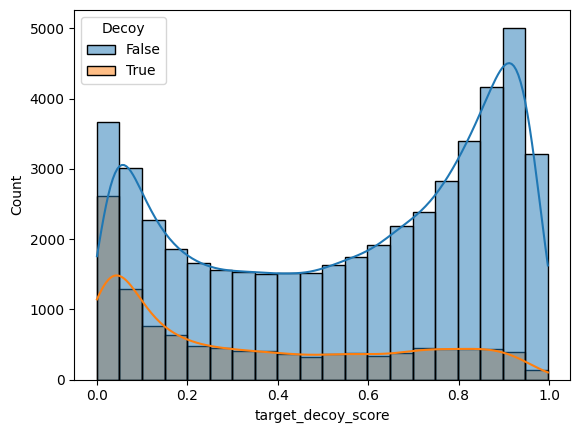

In [233]:
import seaborn as sns

sns.histplot(
    data=pept_act_sum_ps_all_no_loser_tdc.loc[
        pept_act_sum_ps_all_no_loser_tdc["sum_intensity"] > 10
    ],
    x="target_decoy_score",
    bins=20,
    kde=True,
    hue="Decoy",
    common_norm=True,
)

In [234]:
pred_df_new.loc[pred_df_new["target_decoy_score"] > 0.2, "Decoy"].value_counts()

Decoy
False    37763
True      6186
Name: count, dtype: int64

In [235]:
pred_df_new.loc[
    (pred_df_new["target_decoy_score"] > 0.2)
    & (pred_df_new["mz_rank"].isin(difficult_decoy_mz_rank_all))
]["mz_rank"].count()

1591

#### First TDC, then compete for signals

In [236]:
pept_act_sum_ps_all, pept_act_sum_ps_tdc = compete_target_decoy_pair(
    pept_act_sum_ps_all, maxquant_result_ref
)

2024-09-06 14:54:59> FDR after TDC: (Decoy
False    72748
True     16649
Name: count, dtype: int64, 0.22885852532028372)


In [237]:
maxquant_result_ref_tdc = pd.merge(
    left=maxquant_result_ref,
    right=pept_act_sum_ps_tdc["mz_rank"],
    on=["mz_rank"],
    how="right",
)

In [238]:
mz_bin_groups_tdc = (
    maxquant_result_ref_tdc.groupby("mz_bin")
    .filter(lambda x: len(x) > 1)
    .groupby("mz_bin")
)
# Step 3: Apply the function to each group and concatenate the results
signal_compete_tdc = pd.concat(
    [
        generate_signal_compete_pairs_within_group(group)
        for name, group in tqdm(mz_bin_groups_tdc, desc="Processing groups")
    ]
).reset_index(drop=True)

Processing groups: 100%|██████████| 17663/17663 [00:42<00:00, 416.10it/s]


In [239]:
pept_act_sum_ps_tdc, result_after_compete_tdc = compete_candidates_for_signal(
    result=signal_compete_tdc,
    pept_act_sum_ps=pept_act_sum_ps_tdc,
    log_sum_intensity_thres=1,
)

2024-09-06 14:57:44> Number of pairs after filtering rt and im distance: 44289
2024-09-06 14:57:44> Number of pairs after filtering by log sum intensity: 38638
2024-09-06 14:57:44> Number of pairs with delta log intensity < 0.5: 20282
2024-09-06 14:57:49> Number of winners, losers and no competition: competition
no_competition    42946
loser             24165
winner            22286
Name: count, dtype: int64


2024-09-06 15:12:40> Number of entries before filtering: 65232
2024-09-06 15:12:40> Number of entries after filtering by log_sum_intensity with condition [2, 100]: 56996


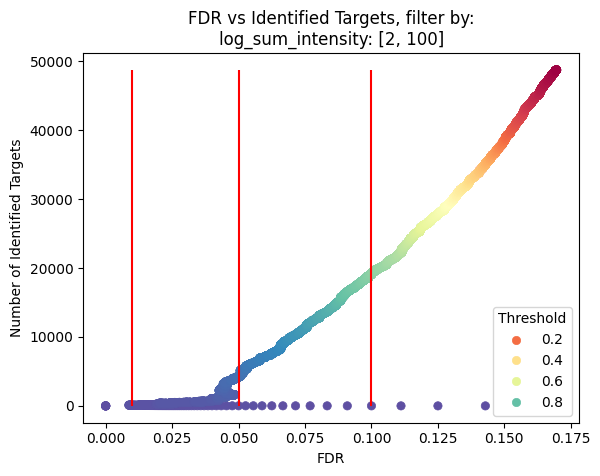

In [261]:
pred_df_new = calc_fdr_and_thres(
    pept_act_sum_ps_tdc.loc[
        (pept_act_sum_ps_tdc["competition"] != "loser")
        # & (~pept_act_sum_ps_tdc["mz_rank"].isin(difficult_decoy_mz_rank_all))
    ],
    filter_dict={"log_sum_intensity": [2, 100]},
    return_plot=True,
)

In [262]:
pred_df_new.loc[(pred_df_new["target_decoy_score"] > 0.2), "Decoy"].value_counts()
pred_df_new.loc[
    (pred_df_new["target_decoy_score"] > 0.2)
    & (pred_df_new["mz_rank"].isin(difficult_decoy_mz_rank_all))
]["mz_rank"].count()

Decoy
False    38982
True      5870
Name: count, dtype: int64

1451

In [310]:
pept_act_sum_ps_log_int_filter = pept_act_sum_ps.loc[
    pept_act_sum_ps["log_sum_intensity"] > 2
]

In [312]:
pept_act_sum_ps_log_int_filter["Decoy"].value_counts()

Decoy
False    67630
True     13529
Name: count, dtype: int64

In [330]:
pept_act_sum_ps_log_int_filter["mz_rank"].isin(isolated_decoys).sum()

9542

In [317]:
pept_act_sum_ps_all_no_loser_log_int_filter = pept_act_sum_ps_all_no_loser.loc[
    pept_act_sum_ps_all_no_loser["log_sum_intensity"] > 2
]

In [318]:
pept_act_sum_ps_all_no_loser_log_int_filter["Decoy"].value_counts()

Decoy
False    52233
True     21814
Name: count, dtype: int64

In [263]:
def check_unique_candidate(
    result_filtered, col_entry1="mz_rank_entry1", col_entry2="mz_rank_entry2"
):
    # Assuming result_filtered is your DataFrame with 'mz_rank_entry1' and 'mz_rank_entry2'
    # Get unique values from each column
    unique_values_entry1 = result_filtered[col_entry1].unique()
    unique_values_entry2 = result_filtered[col_entry2].unique()

    # Combine the unique values from both columns
    all_unique_values = pd.unique(
        pd.concat([pd.Series(unique_values_entry1), pd.Series(unique_values_entry2)])
    )

    # Calculate the total number of unique values
    total_unique_values = len(all_unique_values)
    return total_unique_values


check_unique_candidate(result_filtered_with_score_no_low_int)

91564

In [ ]:
import logging
from itertools import combinations


def compete_pairs(candidates, thres):
    """
    Compete pairs of candidates and eliminate the one with the lowest score
    based on the weighted Intersection over Union (wIoU) metric.

    Args:
        candidates (list): A list of candidate objects.
        thres (float): Threshold for wIoU comparison.

    Returns:
        list: The remaining candidates after competition.
    """
    # Generate all unique pairs from the candidates list
    candidate_pairs = list(combinations(candidates, 2))

    # Iterate through each pair of candidates
    while len(candidate_pairs) > 0:
        (i, j) = candidate_pairs[0]
        # Calculate the weighted IoU between the two candidates
        if wIoU(i, j) > thres:
            # Identify the candidate with the lower score
            loser = i if score(i) < score(j) else j

            # Remove the loser from the candidates list
            candidates = [x for x in candidates if x != loser]

            # Remove all pairs involving the loser
            candidate_pairs = [pair for pair in candidate_pairs if loser not in pair]

            # Log the removal
            logging.info("Removed candidate %s", loser)
        else:
            candidate_pairs.remove((i, j))

    # Return the remaining candidates
    return candidates


# Example placeholder functions for wIoU and score
def wIoU(candidate1, candidate2):
    # This function should compute the weighted Intersection over Union between two candidates
    # Replace this with the actual computation
    return 0.3  # Dummy value


def score(candidate):
    # This function should return a score for a candidate
    # Replace this with actual scoring logic
    return 0.5  # Dummy value

### Target Decoy Log Intensity

In [75]:
pept_act_sum_df_full["Data"] = "Target"
pept_act_sum_df_full.loc[pept_act_sum_df_full["Decoy"], "Data"] = "Decoy"

NameError: name 'pept_act_sum_df_full' is not defined

In [74]:
pept_act_sum_ps_full = pd.merge(
    left=pept_act_sum_df_full,
    right=pept_act_sum_ps,
    on=["mz_rank", "Decoy", "Data"],
    how="left",
    suffixes=("", "_ps"),
)
pept_act_sum_ps_full["log_sum_intensity_ps"].fillna(0, inplace=True)
# # pept_act_sum_ps_full = pept_act_sum_ps
# pept_act_sum_ps_full["Data"] = "Target"
# pept_act_sum_ps_full.loc[pept_act_sum_ps_full["Decoy"], "Data"] = "Decoy"

NameError: name 'pept_act_sum_df_full' is not defined

In [159]:
pept_act_sum_ps_full.loc[
    pept_act_sum_ps_full["target_decoy_score"] < 0.2, "log_sum_intensity_os"
] = 0

In [73]:
ax = sns.histplot(
    pept_act_sum_ps_tdc_all,
    x="log_sum_intensity",
    hue="Data",
    fill=True,
    hue_order=["Decoy", "Target"],
    # palette=custom_cmap,
    multiple="dodge",
    common_norm=True,
    bins=20,
)
plt.xlabel("Log10(Infered Intensity)")
plt.savefig(
    os.path.join(
        ps_exp_dir, "paper_figures", "target_decoy_score_after_ps_and_tdc.png"
    ),
    dpi=300,
    bbox_inches="tight",
)

ValueError: Could not interpret value `Data` for `hue`. An entry with this name does not appear in `data`.

In [161]:
pept_act_sum_ps_full[["log_sum_intensity_ps", "Data"]].value_counts()

log_sum_intensity_ps  Data  
0.000000              Decoy     75806
                      Target    21627
4.853750              Target        2
3.772958              Target        2
4.910022              Target        2
                                ...  
4.277771              Target        1
4.277759              Target        1
4.277755              Target        1
4.277733              Target        1
7.219709              Decoy         1
Name: count, Length: 81312, dtype: int64

In [162]:
pept_act_sum_ps_full["Data"].value_counts()

Data
Decoy     89397
Target    89397
Name: count, dtype: int64

In [164]:
75806 / 89397
21627 / 89397

0.847970289830755

0.24192086982784658

### Protein level FDR

In [97]:
dict_with_int = pd.merge(
    maxquant_result_ref,
    pept_act_sum_ps.loc[
        (pept_act_sum_ps["log_sum_intensity"] > 2)
        & (pept_act_sum_ps["target_decoy_score"] >= 0.55)
    ],
    on=["mz_rank", "Decoy"],
    how="inner",
)
dict_with_int["Leading razor proteins_td_labeled"] = dict_with_int["Proteins"].str.cat(
    dict_with_int["Decoy"].astype(str), sep="_"
)
td_protein_count = (
    dict_with_int.groupby(["Leading razor proteins_td_labeled", "Decoy"])["Sequence"]
    .count()
    .reset_index()
)

In [99]:
td_protein_count_filtered = td_protein_count.loc[td_protein_count["Sequence"] >= 2]
td_protein_count_filtered["Decoy"].value_counts()

Decoy
False    4441
True     1316
Name: count, dtype: int64

### Batch effect trouble shooting

In [59]:
pept_act_sum_df = pept_act_sum_ps

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='log_sum_intensity', ylabel='Density'>

Text(0.5, 1.0, 'Batch effect from different source in Intensity')

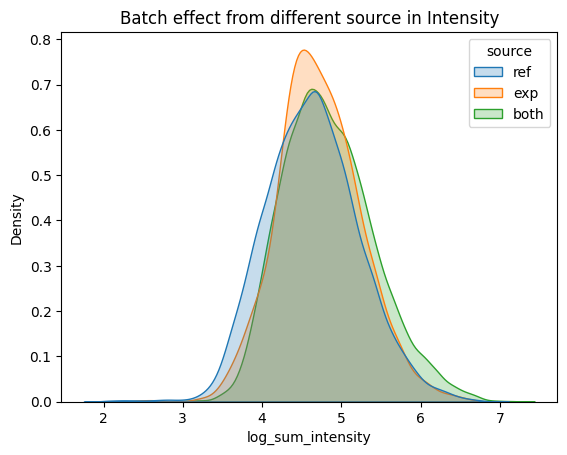

In [62]:
import seaborn as sns

dict_with_int_all = pd.merge(maxquant_result_ref, pept_act_sum_df, on=["mz_rank"])
dict_with_int_all = dict_with_int_all.loc[dict_with_int_all["Decoy"] == 0]
sns.kdeplot(
    data=dict_with_int,
    x="log_sum_intensity",
    hue="source",
    fill=True,
    common_norm=False,
)
plt.title("Batch effect from different source in Intensity")
plt.savefig(
    os.path.join(ps_exp_dir, "results", "batch_effect_intensity_target.png"), dpi=300
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='target_decoy_score', ylabel='Density'>

Text(0.5, 1.0, 'Batch effect from different source in target-decoy score')

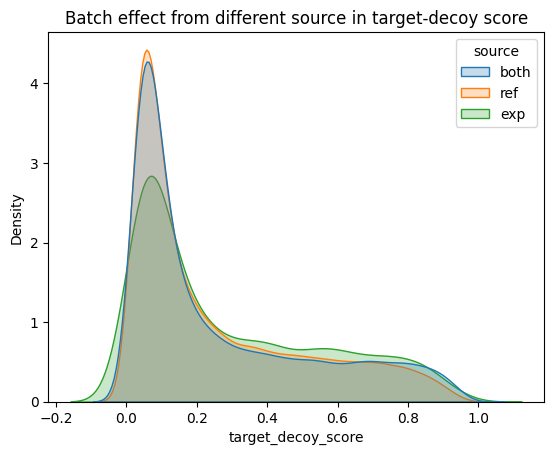

In [69]:
dict_with_int_all = pd.merge(
    maxquant_result_ref, pept_act_sum_df, on=["mz_rank"], how="inner"
)
dict_with_int_all = dict_with_int_all.loc[dict_with_int_all["Decoy"]]
sns.kdeplot(
    data=dict_with_int_all,
    x="target_decoy_score",
    hue="source",
    fill=True,
    common_norm=False,
)
plt.title("Batch effect from different source in target-decoy score")
plt.savefig(
    os.path.join(ps_exp_dir, "results", "batch_effect_td_score_decoy.png"), dpi=300
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='target_decoy_score', ylabel='Density'>

Text(0.5, 1.0, 'Batch effect from different source in target-decoy score')

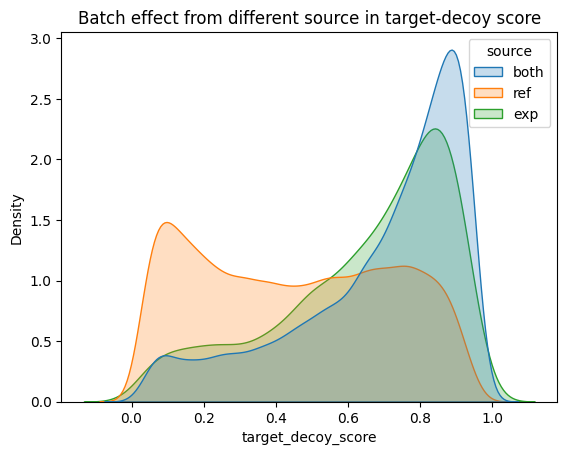

In [70]:
dict_with_int_all = pd.merge(maxquant_result_ref, pept_act_sum_df, on=["mz_rank"])
dict_with_int_all = dict_with_int_all.loc[dict_with_int_all["Decoy"] == 0]
sns.kdeplot(
    data=dict_with_int_all,
    x="target_decoy_score",
    hue="source",
    fill=True,
    common_norm=False,
)

plt.title("Batch effect from different source in target-decoy score")
plt.savefig(
    os.path.join(ps_exp_dir, "results", "batch_effect_td_score_target.png"), dpi=300
)

/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='target_decoy_score', ylabel='Density'>

Text(0.5, 1.0, 'Batch effect on target_decoy_score')

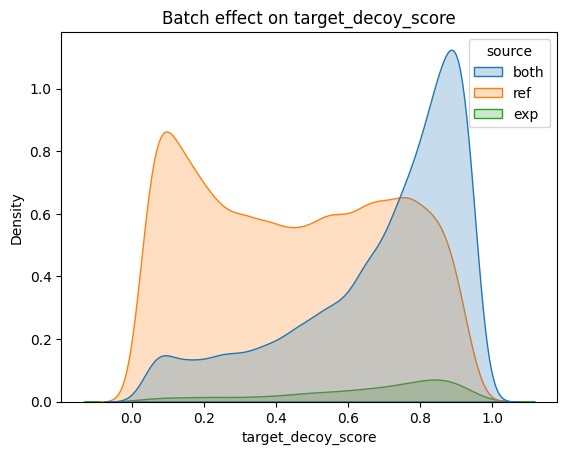

In [71]:
sns.kdeplot(
    data=dict_with_int_all,
    x="target_decoy_score",
    hue="source",
    fill=True,
    common_norm=True,
)
plt.title("Batch effect on target_decoy_score")